# The first lab results will be used to predict patient diagnoses for the X most common causes of death in ICU patients recorded in the MIMIC III database.

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).

In [1]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.style.use('ggplot') 
%matplotlib inline

# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
The mimic III database was queried for information regarding ICD-9 codes and corresponding plain text diagnosis for patients who died while in the hospital. Data was then imported and analyzed to determine the X most common codes/diagnoses. 


In [23]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes['icustay_id'] = diagnoses_codes.index
diagnoses_codes.set_index(np.arange(diagnoses_codes.shape[0]), inplace = True)

diagnoses_codes.head()

diagnosis icd9_code               short_title  icustay_id
0   DYSPNEA     48241  Meth sus pneum d/t Staph      280836
1   DYSPNEA      4280                   CHF NOS      280836
2   DYSPNEA     51881  Acute respiratry failure      280836
3   DYSPNEA      5845  Ac kidny fail, tubr necr      280836
4   DYSPNEA      4275            Cardiac arrest      280836

In [5]:
diagnoses_codes.shape

(94763, 3)

In [4]:
# data was grouped by the IDC-9 code and the plain text diagnoses. It appears that multiple codes may correspond 
# to the same plain text diagnoses so the same will be done for just ICD-9 codes and just plain text to verify. 
diagnoses_counts = diagnoses_codes.groupby(['icd9_code', 'short_title']).count()
diagnoses_counts.shape

(3254, 1)

In [17]:
diagnoses_counts.sort(['diagnosis'], ascending = False).head()

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


diagnosis
icd9_code short_title                        
51881     Acute respiratry failure       2668
4019      Hypertension NOS               2260
42731     Atrial fibrillation            2237
4280      CHF NOS                        2195
5849      Acute kidney failure NOS       2132

In [30]:
# data was grouped by the IDC-9 code and the plain text diagnoses. It appears that multiple codes may correspond 
# to the same plain text diagnoses so the same will be done for just ICD-9 codes and just plain text to verify. 
diagnoses_codes_unique = diagnoses_codes.drop_duplicates('icustay_id')
diagnoses_counts3 = diagnoses_codes_unique.groupby(['diagnosis']).count()

display(diagnoses_counts3.shape)
diagnoses_counts3.head()


(2337, 3)

icd9_code  short_title  \
diagnosis                                                              
 ? SEROTONIN SYNDROME                                 1            1   
(AML) ACUTE MYELOGENOUS LEUKEMIA                      6            6   
(AML) ACUTE MYELOGENOUS LEUKEMIA;HYPOTENSION          1            1   
0681                                                  1            1   
12-AQV                                                1            1   

                                              icustay_id  
diagnosis                                                 
 ? SEROTONIN SYNDROME                                  1  
(AML) ACUTE MYELOGENOUS LEUKEMIA                       6  
(AML) ACUTE MYELOGENOUS LEUKEMIA;HYPOTENSION           1  
0681                                                   1  
12-AQV                                                 1

In [31]:
diagnoses_counts3.sort(['icustay_id'], ascending = False).head(10)

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


icd9_code  short_title  icustay_id
diagnosis                                                   
SEPSIS                          311          311         311
PNEUMONIA                       289          289         289
INTRACRANIAL HEMORRHAGE         241          241         241
CONGESTIVE HEART FAILURE        145          145         145
ALTERED MENTAL STATUS           100          100         100
ABDOMINAL PAIN                   96           96          96
HYPOTENSION                      90           90          90
S/P FALL                         84           84          84
CARDIAC ARREST                   79           79          79
SUBARACHNOID HEMORRHAGE          72           72          72

In [18]:
# data was grouped by the IDC-9 code and the plain text diagnoses. It appears that multiple codes may correspond 
# to the same plain text diagnoses so the same will be done for just ICD-9 codes and just plain text to verify. 
diagnoses_counts3 = diagnoses_codes.groupby(['diagnosis']).count()
display(diagnoses_counts3.shape)
diagnoses_counts3.head()


(2337, 2)

icd9_code  short_title
diagnosis                                                           
 ? SEROTONIN SYNDROME                                12           12
(AML) ACUTE MYELOGENOUS LEUKEMIA                    106          106
(AML) ACUTE MYELOGENOUS LEUKEMIA;HYPOTENSION         25           25
0681                                                  6            6
12-AQV                                               27           27

## The number of patients admitted with a given diagnoses and who passed away while in the hospital was calculated for all diagnoses. The results indicate that Sepsis, Pneumonia, Congestive Heart Failure and Intracranial Hemorrhage were the 4 most common, deadly diagnoses. 

In [20]:
diagnoses_counts3.sort(['icd9_code'], ascending = False).head(10)

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


icd9_code  short_title
diagnosis                                       
SEPSIS                         5145         5145
PNEUMONIA                      4497         4497
CONGESTIVE HEART FAILURE       2379         2379
INTRACRANIAL HEMORRHAGE        2138         2138
ALTERED MENTAL STATUS          1706         1706
ABDOMINAL PAIN                 1683         1683
HYPOTENSION                    1536         1536
FEVER                          1066         1066
S/P FALL                       1045         1045
CARDIAC ARREST                  973          973

In [ ]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape

diag_counts = diagnoses_codes.icd9_code.value_counts()
diag_counts[0:10]
diagnoses_list[0:10]

## The database was queried to find initial lab results for patients diagnosed with any of the four previously identified diagnoses.  

In [21]:
lab_results = pd.DataFrame.from_csv('DEADLY_DIAGNOSES.csv')
lab_results.groupby('diagnosis').count()

hadm_id  icustay_id  mort_icu  mort_hosp  \
subject_id                                             
21           109451      217847         0          0   
21           111970      216859         1          1   
37           188670      213503         0          0   
42           119203      210828         0          0   
68           170467      225771         0          0   

                           diagnosis  aniongap_1st  albumin_1st  \
subject_id                                                        
21          CONGESTIVE HEART FAILURE          26.0          NaN   
21                            SEPSIS          19.0          2.1   
37          CONGESTIVE HEART FAILURE          10.0          NaN   
42          CONGESTIVE HEART FAILURE          14.0          3.6   
68                         PNEUMONIA          15.0          NaN   

            bicarbonate_1st  bilirubin_1st  creatinine_1st   ...     \
subject_id                                                   ...      
21                     15.0            0.4             3.7   ...      
21                     23.0            0.3             4.2   ...      
37                     33.0            NaN             1.0   ...      
42                     25.0            0.3             0.7   ...      
68                     22.0            NaN             2.2   ...      

            magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
subject_id                                                              
21                    2.0            5.9         261.0            5.0   
21                    1.5            4.4         275.0            3.8   
37                    2.2            3.9         263.0            4.0   
42                    1.9            2.8         228.0            4.3   
68                    2.1            3.8          95.0            3.4   

            ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
subject_id                                                          
21            150.0      4.0    23.5       140.0     94.0     23.5  
21             31.7      1.7    18.1       137.0     49.0     30.5  
37             24.6      1.2    13.3       139.0     37.0     10.4  
42             25.7      1.6    15.4       139.0     18.0      7.9  
68              NaN      NaN     NaN       134.0     32.0      1.9  

[5 rows x 25 columns]

## Perform count of the number of lab results that exist per diagnosis

In [32]:
lab_results2 = lab_results.groupby(['diagnosis']).count()
display(lab_results2.shape)
lab_results2.head(10)

(4, 24)

hadm_id  icustay_id  mort_icu  mort_hosp  \
diagnosis                                                            
CONGESTIVE HEART FAILURE     1025        1025      1025       1025   
INTRACRANIAL HEMORRHAGE       754         754       754        754   
PNEUMONIA                    1662        1662      1662       1662   
SEPSIS                       1290        1290      1290       1290   

                          aniongap_1st  albumin_1st  bicarbonate_1st  \
diagnosis                                                              
CONGESTIVE HEART FAILURE          1005          330             1011   
INTRACRANIAL HEMORRHAGE            717          243              718   
PNEUMONIA                         1646          671             1649   
SEPSIS                            1275          824             1275   

                          bilirubin_1st  creatinine_1st  chloride_1st  \
diagnosis                                                               
CONGESTIVE HEART FAILURE            406            1013          1013   
INTRACRANIAL HEMORRHAGE             254             735           732   
PNEUMONIA                           866            1651          1652   
SEPSIS                             1000            1277          1279   

                           ...     magnesium_1st  phosphate_1st  platelet_1st  \
diagnosis                  ...                                                  
CONGESTIVE HEART FAILURE   ...               986            941          1010   
INTRACRANIAL HEMORRHAGE    ...               684            681           732   
PNEUMONIA                  ...              1604           1588          1648   
SEPSIS                     ...              1257           1256          1275   

                          potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  \
diagnosis                                                                       
CONGESTIVE HEART FAILURE           1013      897      899     899        1013   
INTRACRANIAL HEMORRHAGE             734      712      714     715         732   
PNEUMONIA                          1652     1387     1400    1400        1652   
SEPSIS                             1279     1185     1189    1189        1279   

                          bun_1st  wbc_1st  
diagnosis                                   
CONGESTIVE HEART FAILURE     1012     1010  
INTRACRANIAL HEMORRHAGE       735      732  
PNEUMONIA                    1651     1649  
SEPSIS                       1277     1274  

[4 rows x 24 columns]

## Many of the lab recordings were unavailable and are entered as NaN. The methods below utilizes the Imputer function.
The imputer function can extrapolate missing values from existing values a number of ways. The 'mean' method replaces missing values with the calculated mean for the column. We will be a bit more targeted in that we would like the missing values in a given category of diagnosis to be replaced by the mean of the values within that category. The dataframe will be split according to diagnosis, values will imputed, then the dataset will be reconstructed. 

In [34]:

cong_hf = lab_results[lab_results['diagnosis'] == 'CONGESTIVE HEART FAILURE']
cong_hf.head()

hadm_id  icustay_id  mort_icu  mort_hosp  \
subject_id                                             
21           109451      217847         0          0   
37           188670      213503         0          0   
42           119203      210828         0          0   
164          182743      218740         1          1   
305          122211      224571         0          0   

                           diagnosis  aniongap_1st  albumin_1st  \
subject_id                                                        
21          CONGESTIVE HEART FAILURE          26.0          NaN   
37          CONGESTIVE HEART FAILURE          10.0          NaN   
42          CONGESTIVE HEART FAILURE          14.0          3.6   
164         CONGESTIVE HEART FAILURE          14.0          NaN   
305         CONGESTIVE HEART FAILURE          10.0          NaN   

            bicarbonate_1st  bilirubin_1st  creatinine_1st   ...     \
subject_id                                                   ...      
21                     15.0            0.4             3.7   ...      
37                     33.0            NaN             1.0   ...      
42                     25.0            0.3             0.7   ...      
164                    26.0            NaN             0.6   ...      
305                    29.0            NaN             0.7   ...      

            magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
subject_id                                                              
21                    2.0            5.9         261.0            5.0   
37                    2.2            3.9         263.0            4.0   
42                    1.9            2.8         228.0            4.3   
164                   1.8            3.4         145.0            4.2   
305                   1.9            3.6         259.0            3.7   

            ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
subject_id                                                          
21            150.0      4.0    23.5       140.0     94.0     23.5  
37             24.6      1.2    13.3       139.0     37.0     10.4  
42             25.7      1.6    15.4       139.0     18.0      7.9  
164            46.1      7.1    33.5       138.0     25.0     16.4  
305             NaN      NaN     NaN       141.0     19.0      4.4  

[5 rows x 25 columns]

In [66]:
lab_results.diagnosis.unique()

array(['CONGESTIVE HEART FAILURE', 'SEPSIS', 'PNEUMONIA',
       'INTRACRANIAL HEMORRHAGE'], dtype=object)

In [67]:
cong_hf_features = lab_results[lab_results['diagnosis'] == 'CONGESTIVE HEART FAILURE'][lab_results.columns[5:]]
cong_hf_labels = lab_results[lab_results['diagnosis'] == 'CONGESTIVE HEART FAILURE'][lab_results.columns[:5]]
seps_features = lab_results[lab_results['diagnosis'] == 'SEPSIS'][lab_results.columns[5:]]
seps_labels = lab_results[lab_results['diagnosis'] == 'SEPSIS'][lab_results.columns[:5]]
pneum_features = lab_results[lab_results['diagnosis'] == 'PNEUMONIA'][lab_results.columns[5:]]
pneum_labels = lab_results[lab_results['diagnosis'] == 'PNEUMONIA'][lab_results.columns[:5]]
intracran_features = lab_results[lab_results['diagnosis'] == 'INTRACRANIAL HEMORRHAGE'][lab_results.columns[5:]]
intracran_labels = lab_results[lab_results['diagnosis'] == 'INTRACRANIAL HEMORRHAGE'][lab_results.columns[:5]]
display(cong_hf_features.shape)
display(seps_features.shape)
display(pneum_features.shape)
display(intracran_features.shape)

(1025, 20)

(1290, 20)

(1662, 20)

(754, 20)

## Example code for how to impute dataframe by column

In [53]:
cong_hf_features2 = cong_hf_features.copy()
cong_hf_features2['aniongap_1st'] = imp.fit_transform(cong_hf_features[['aniongap_1st']]).ravel()


In [55]:
cong_hf_features2['aniongap_1st'].isnull().sum()

0

## Impute dataframe containing lab results for each diagnoses


In [71]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
cong_hf_imp = pd.DataFrame(imp.fit_transform(cong_hf_features))
cong_hf_imp.columns = cong_hf_features.columns
cong_hf_imp.index = cong_hf_features.index
seps_imp = pd.DataFrame(imp.fit_transform(seps_features))
seps_imp.columns = seps_features.columns
seps_imp.index = seps_features.index
pneum_imp = pd.DataFrame(imp.fit_transform(pneum_features))
pneum_imp.columns = pneum_features.columns
pneum_imp.index = pneum_features.index
intracran_imp = pd.DataFrame(imp.fit_transform(intracran_features))
intracran_imp.columns = intracran_features.columns
intracran_imp.index = intracran_features.index

In [48]:
cong_hf_imp.isnull().sum()

aniongap_1st       0
albumin_1st        0
bicarbonate_1st    0
bilirubin_1st      0
creatinine_1st     0
chloride_1st       0
glucose_1st        0
hematocrit_1st     0
hemoglobin_1st     0
lactate_1st        0
magnesium_1st      0
phosphate_1st      0
platelet_1st       0
potassium_1st      0
ptt_1st            0
inr_1st            0
pt_1st             0
sodium_1st         0
bun_1st            0
wbc_1st            0
dtype: int64

## Reconstruct individual diagnostic dataframes to include lab results, targets and demographic data

In [72]:
cong_hf_imputed = pd.concat([cong_hf_labels, cong_hf_imp], axis=1, join_axes=[cong_hf_labels.index])
seps_imputed = pd.concat([seps_labels, seps_imp], axis = 1, join_axes = [seps_labels.index])
pneum_imputed = pd.concat([pneum_labels, pneum_imp], axis = 1, join_axes = [pneum_labels.index])
intracran_imputed = pd.concat([intracran_labels, intracran_imp], axis = 1, join_axes = [intracran_labels.index])

## Verify that columns are the same for each dataframe

In [77]:
cong_hf_imputed.columns == seps_imputed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [76]:
seps_imputed.columns ==  pneum_imputed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [78]:
pneum_imputed.columns == intracran_imputed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

## Reconstruct entire dataframe to include info and data for all diagnoses

In [79]:
data_imputed = pd.concat([cong_hf_imputed, seps_imputed, pneum_imputed, intracran_imputed])
data_imputed.head()

hadm_id  icustay_id  mort_icu  mort_hosp  \
subject_id                                             
21           109451      217847         0          0   
37           188670      213503         0          0   
42           119203      210828         0          0   
164          182743      218740         1          1   
305          122211      224571         0          0   

                           diagnosis  aniongap_1st  albumin_1st  \
subject_id                                                        
21          CONGESTIVE HEART FAILURE          26.0     3.400606   
37          CONGESTIVE HEART FAILURE          10.0     3.400606   
42          CONGESTIVE HEART FAILURE          14.0     3.600000   
164         CONGESTIVE HEART FAILURE          14.0     3.400606   
305         CONGESTIVE HEART FAILURE          10.0     3.400606   

            bicarbonate_1st  bilirubin_1st  creatinine_1st   ...     \
subject_id                                                   ...      
21                     15.0       0.400000             3.7   ...      
37                     33.0       0.888916             1.0   ...      
42                     25.0       0.300000             0.7   ...      
164                    26.0       0.888916             0.6   ...      
305                    29.0       0.888916             0.7   ...      

            magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
subject_id                                                              
21                    2.0            5.9         261.0            5.0   
37                    2.2            3.9         263.0            4.0   
42                    1.9            2.8         228.0            4.3   
164                   1.8            3.4         145.0            4.2   
305                   1.9            3.6         259.0            3.7   

               ptt_1st   inr_1st     pt_1st  sodium_1st  bun_1st  wbc_1st  
subject_id                                                                 
21          150.000000  4.000000  23.500000       140.0     94.0     23.5  
37           24.600000  1.200000  13.300000       139.0     37.0     10.4  
42           25.700000  1.600000  15.400000       139.0     18.0      7.9  
164          46.100000  7.100000  33.500000       138.0     25.0     16.4  
305          39.892754  1.797453  18.313793       141.0     19.0      4.4  

[5 rows x 25 columns]

## Verify that there are no null values in the imputed dataframe

In [84]:
data_imputed.isnull().sum()

hadm_id            0
icustay_id         0
mort_icu           0
mort_hosp          0
diagnosis          0
aniongap_1st       0
albumin_1st        0
bicarbonate_1st    0
bilirubin_1st      0
creatinine_1st     0
chloride_1st       0
glucose_1st        0
hematocrit_1st     0
hemoglobin_1st     0
lactate_1st        0
magnesium_1st      0
phosphate_1st      0
platelet_1st       0
potassium_1st      0
ptt_1st            0
inr_1st            0
pt_1st             0
sodium_1st         0
bun_1st            0
wbc_1st            0
dtype: int64

In [83]:
lab_results.isnull().sum()

hadm_id               0
icustay_id            0
mort_icu              0
mort_hosp             0
diagnosis             0
aniongap_1st         88
albumin_1st        2663
bicarbonate_1st      78
bilirubin_1st      2205
creatinine_1st       55
chloride_1st         55
glucose_1st          57
hematocrit_1st       62
hemoglobin_1st       64
lactate_1st        1186
magnesium_1st       200
phosphate_1st       265
platelet_1st         66
potassium_1st        53
ptt_1st             550
inr_1st             529
pt_1st              528
sodium_1st           55
bun_1st              56
wbc_1st              66
dtype: int64

## Code to confirm that there are no duplicate lab results for the same ICU stay. The initial results were selected by bracketing a time around admission and it may have been possible to get more than one set of results. 

In [91]:
data_imputed2 = data_imputed.drop_duplicates( subset = ['icustay_id'], keep = 'first')
data_imputed2.shape == data_imputed.shape

True

In [89]:
data_imputed2.columns

Index([u'hadm_id', u'icustay_id', u'mort_icu', u'mort_hosp', u'diagnosis',
       u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st', u'bilirubin_1st',
       u'creatinine_1st', u'chloride_1st', u'glucose_1st', u'hematocrit_1st',
       u'hemoglobin_1st', u'lactate_1st', u'magnesium_1st', u'phosphate_1st',
       u'platelet_1st', u'potassium_1st', u'ptt_1st', u'inr_1st', u'pt_1st',
       u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')

In [150]:
data_imputed['subject_id'] = data_imputed.index
data_imputed.head()

mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
subject_id                                                                   
21                  0  CONGESTIVE HEART FAILURE          26.0     3.400606   
37                  0  CONGESTIVE HEART FAILURE          10.0     3.400606   
42                  0  CONGESTIVE HEART FAILURE          14.0     3.600000   
164                 1  CONGESTIVE HEART FAILURE          14.0     3.400606   
305                 0  CONGESTIVE HEART FAILURE          10.0     3.400606   

            bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  \
subject_id                                                                 
21                     15.0       0.400000             3.7         104.0   
37                     33.0       0.888916             1.0         100.0   
42                     25.0       0.300000             0.7         104.0   
164                    26.0       0.888916             0.6         102.0   
305                    29.0       0.888916             0.7         106.0   

            glucose_1st  hematocrit_1st     ...      phosphate_1st  \
subject_id                                  ...                      
21                161.0            27.0     ...                5.9   
37                265.0            28.9     ...                3.9   
42                157.0            37.4     ...                2.8   
164               123.0            33.8     ...                3.4   
305               143.0            25.9     ...                3.6   

            platelet_1st  potassium_1st     ptt_1st   inr_1st     pt_1st  \
subject_id                                                                 
21                 261.0            5.0  150.000000  4.000000  23.500000   
37                 263.0            4.0   24.600000  1.200000  13.300000   
42                 228.0            4.3   25.700000  1.600000  15.400000   
164                145.0            4.2   46.100000  7.100000  33.500000   
305                259.0            3.7   39.892754  1.797453  18.313793   

            sodium_1st  bun_1st  wbc_1st  subject_id  
subject_id                                            
21               140.0     94.0     23.5          21  
37               139.0     37.0     10.4          37  
42               139.0     18.0      7.9          42  
164              138.0     25.0     16.4         164  
305              141.0     19.0      4.4         305  

[5 rows x 23 columns]

In [152]:
data_imputed.shape[0]

4731

In [153]:
data_imputed.set_index(np.arange(data_imputed.shape[0]), inplace = True)
data_imputed.head()

mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
0          0  CONGESTIVE HEART FAILURE          26.0     3.400606   
1          0  CONGESTIVE HEART FAILURE          10.0     3.400606   
2          0  CONGESTIVE HEART FAILURE          14.0     3.600000   
3          1  CONGESTIVE HEART FAILURE          14.0     3.400606   
4          0  CONGESTIVE HEART FAILURE          10.0     3.400606   

   bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  \
0             15.0       0.400000             3.7         104.0        161.0   
1             33.0       0.888916             1.0         100.0        265.0   
2             25.0       0.300000             0.7         104.0        157.0   
3             26.0       0.888916             0.6         102.0        123.0   
4             29.0       0.888916             0.7         106.0        143.0   

   hematocrit_1st     ...      phosphate_1st  platelet_1st  potassium_1st  \
0            27.0     ...                5.9         261.0            5.0   
1            28.9     ...                3.9         263.0            4.0   
2            37.4     ...                2.8         228.0            4.3   
3            33.8     ...                3.4         145.0            4.2   
4            25.9     ...                3.6         259.0            3.7   

      ptt_1st   inr_1st     pt_1st  sodium_1st  bun_1st  wbc_1st  subject_id  
0  150.000000  4.000000  23.500000       140.0     94.0     23.5          21  
1   24.600000  1.200000  13.300000       139.0     37.0     10.4          37  
2   25.700000  1.600000  15.400000       139.0     18.0      7.9          42  
3   46.100000  7.100000  33.500000       138.0     25.0     16.4         164  
4   39.892754  1.797453  18.313793       141.0     19.0      4.4         305  

[5 rows x 23 columns]

## From original data set, drop rows in which there are NaN values

In [209]:
lab_results2 = lab_results.copy()
lab_results2.dropna(inplace=True)
lab_results2.shape

(1439, 25)

In [210]:
lab_results2.groupby('diagnosis').count()

hadm_id  icustay_id  mort_icu  mort_hosp  \
diagnosis                                                            
CONGESTIVE HEART FAILURE      167         167       167        167   
INTRACRANIAL HEMORRHAGE       104         104       104        104   
PNEUMONIA                     480         480       480        480   
SEPSIS                        688         688       688        688   

                          aniongap_1st  albumin_1st  bicarbonate_1st  \
diagnosis                                                              
CONGESTIVE HEART FAILURE           167          167              167   
INTRACRANIAL HEMORRHAGE            104          104              104   
PNEUMONIA                          480          480              480   
SEPSIS                             688          688              688   

                          bilirubin_1st  creatinine_1st  chloride_1st  \
diagnosis                                                               
CONGESTIVE HEART FAILURE            167             167           167   
INTRACRANIAL HEMORRHAGE             104             104           104   
PNEUMONIA                           480             480           480   
SEPSIS                              688             688           688   

                           ...     magnesium_1st  phosphate_1st  platelet_1st  \
diagnosis                  ...                                                  
CONGESTIVE HEART FAILURE   ...               167            167           167   
INTRACRANIAL HEMORRHAGE    ...               104            104           104   
PNEUMONIA                  ...               480            480           480   
SEPSIS                     ...               688            688           688   

                          potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  \
diagnosis                                                                       
CONGESTIVE HEART FAILURE            167      167      167     167         167   
INTRACRANIAL HEMORRHAGE             104      104      104     104         104   
PNEUMONIA                           480      480      480     480         480   
SEPSIS                              688      688      688     688         688   

                          bun_1st  wbc_1st  
diagnosis                                   
CONGESTIVE HEART FAILURE      167      167  
INTRACRANIAL HEMORRHAGE       104      104  
PNEUMONIA                     480      480  
SEPSIS                        688      688  

[4 rows x 24 columns]

In [211]:
lab_results2.set_index(np.arange(lab_results2.shape[0]), inplace = True)

In [212]:
lab_results2.drop(['hadm_id', 'icustay_id', 'mort_icu'], axis=1, inplace = True)
lab_results2.head()

mort_hosp  diagnosis  aniongap_1st  albumin_1st  bicarbonate_1st  \
0          1     SEPSIS          19.0          2.1             23.0   
1          1  PNEUMONIA          22.0          1.9             21.0   
2          0     SEPSIS          14.0          2.9             17.0   
3          0  PNEUMONIA          14.0          2.3             17.0   
4          1  PNEUMONIA          13.0          3.4             31.0   

   bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
0            0.3             4.2          99.0        200.0            29.6   
1            0.4             2.1         100.0        130.0            43.0   
2            1.8             2.4          99.0         66.0            35.1   
3            1.0             1.7         111.0        164.0            22.2   
4            0.7             1.1          94.0        134.0            30.8   

    ...     magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
0   ...               1.5            4.4         275.0            3.8   
1   ...               1.9            9.1         212.0            3.9   
2   ...               1.0            3.3         266.0            5.0   
3   ...               1.7            3.3         135.0            3.4   
4   ...               1.9            3.5         127.0            4.7   

   ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0     31.7      1.7    18.1       137.0     49.0     30.5  
1     72.1      2.7    27.2       139.0     46.0     21.2  
2     32.7      1.2    13.7       133.0     31.0     16.7  
3    150.0      1.5    16.1       139.0     40.0      9.8  
4     45.2      1.5    16.0       137.0     19.0      7.0  

[5 rows x 22 columns]

In [165]:
# create a list of columns that only includes lab measures for use in analysis
lab_measures = list(data_imputed.columns[2:])
lab_measures.sort()
#print lab_measures
# a dictionary is created which contains normal ranges for lab measurements 
lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }


'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict

{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mg/dL', 'hematocrit_1st': '%', 'chloride_1st': 'mEq/L', 'lactate_1st': 'mmol/L', 'potassium_1st': 'mEq/L', 'glucose_1st': 'mg/dL', 'creatinine_1st': 'mg/dL', 'magnesium_1st': 'mmol/L', 'aniongap_1st': 'mEq/L', 'pt_1st': '', 'hemoglobin_1st': 'g/dL', 'ptt_1st': 'sec', 'albumin_1st': 'g/dL', 'bun_1st': '', 'inr_1st': '', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'mmol/L', 'platelet_1st': 'K/uL'}


In [167]:
diagnoses_list = data_imputed.diagnosis.unique()
display(diagnoses)

array(['CONGESTIVE HEART FAILURE', 'SEPSIS', 'PNEUMONIA',
       'INTRACRANIAL HEMORRHAGE'], dtype=object)

In [171]:
for i, u in labs_dict.iteritems():
    print "{}   {}".format(i, u)

wbc_1st   
bicarbonate_1st   mEq/L
phosphate_1st   mg/dL
hematocrit_1st   %
chloride_1st   mEq/L
lactate_1st   mmol/L
potassium_1st   mEq/L
glucose_1st   mg/dL
creatinine_1st   mg/dL
magnesium_1st   mmol/L
aniongap_1st   mEq/L
pt_1st   
hemoglobin_1st   g/dL
ptt_1st   sec
albumin_1st   g/dL
bun_1st   
inr_1st   
bilirubin_1st   mg/dL
sodium_1st   mmol/L
platelet_1st   K/uL


In [164]:
l

'subject_id'

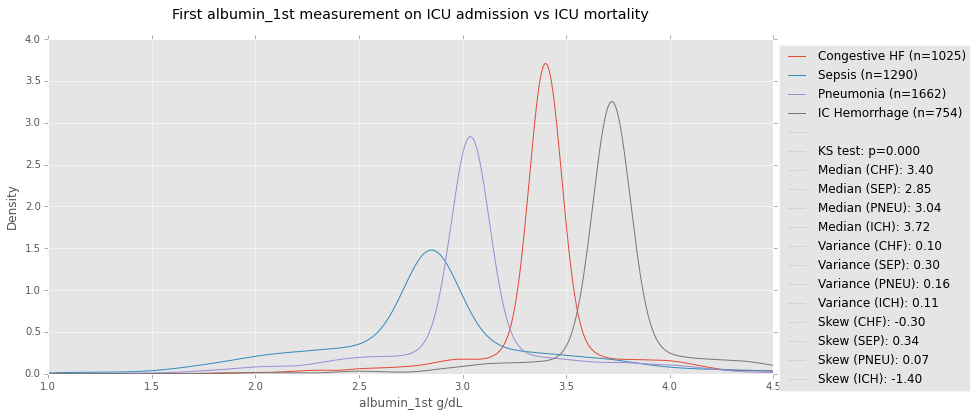

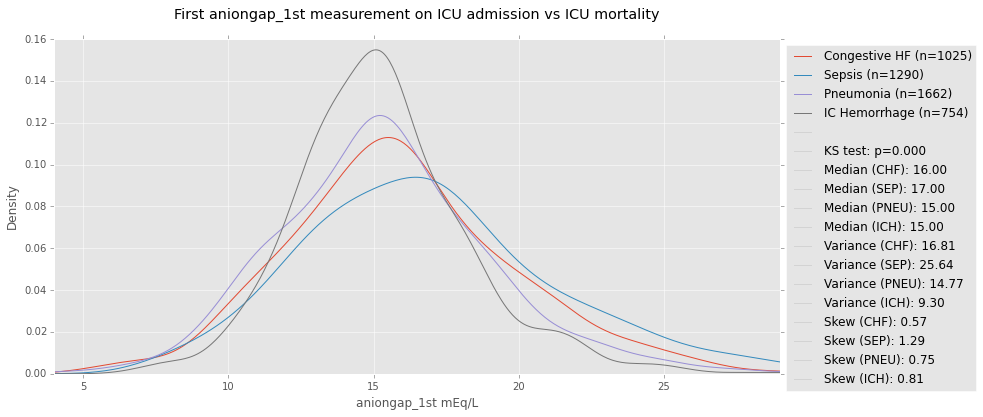

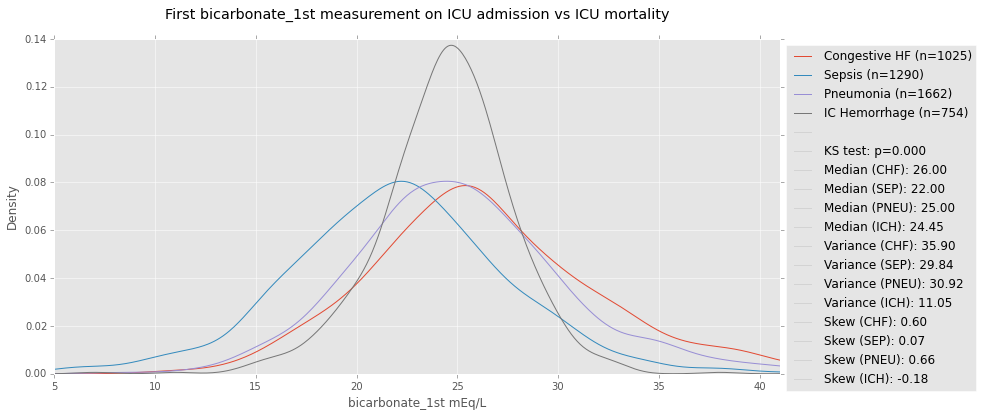

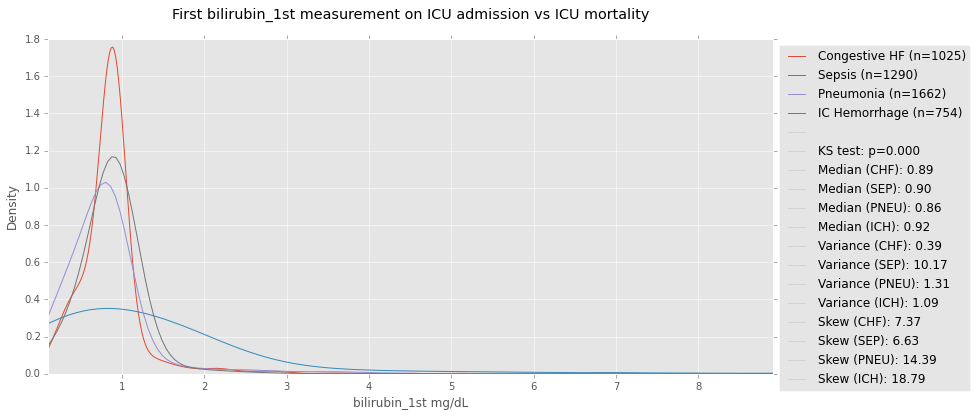

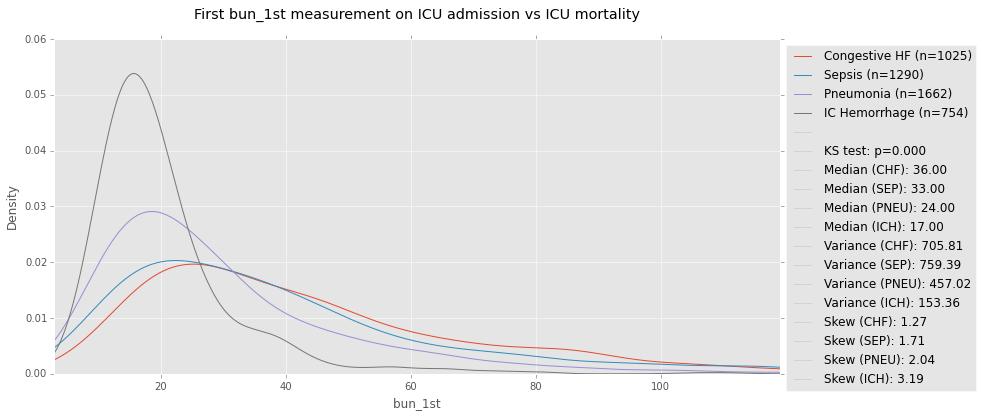

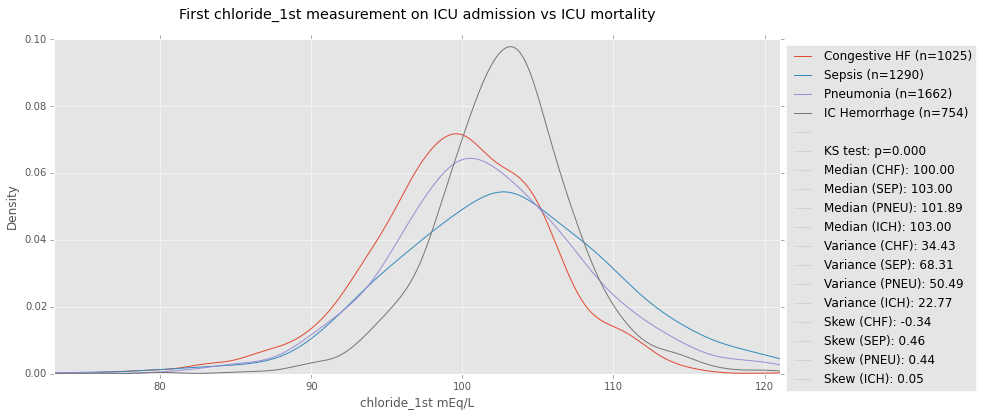

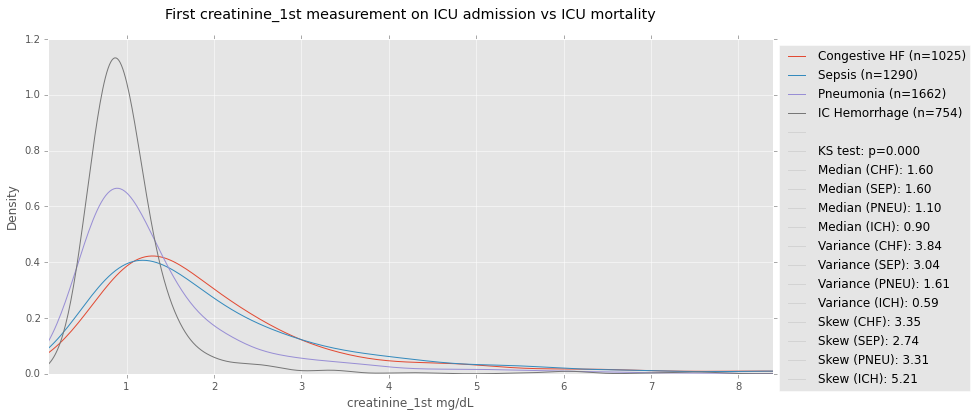

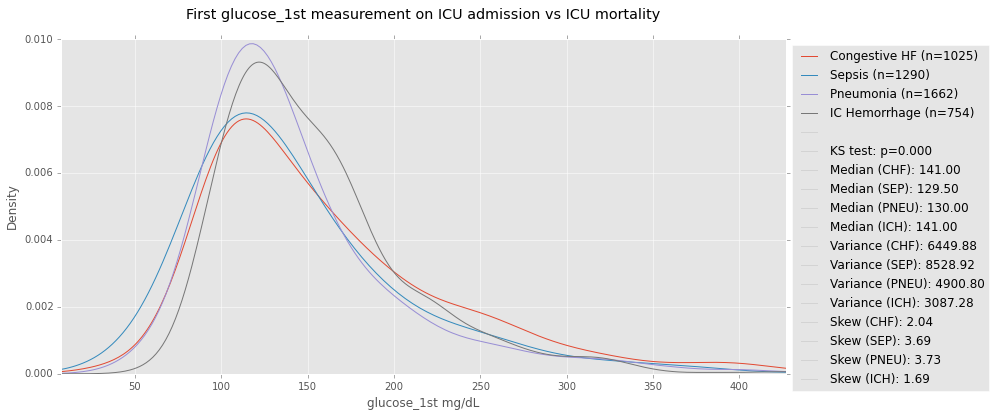

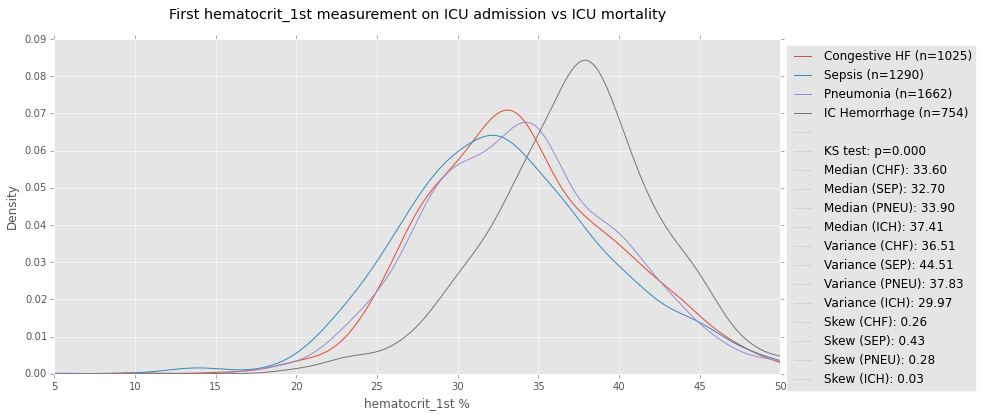

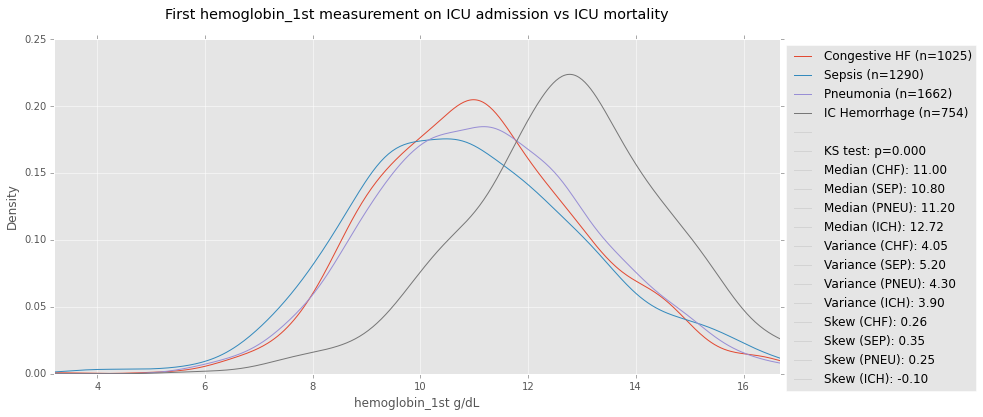

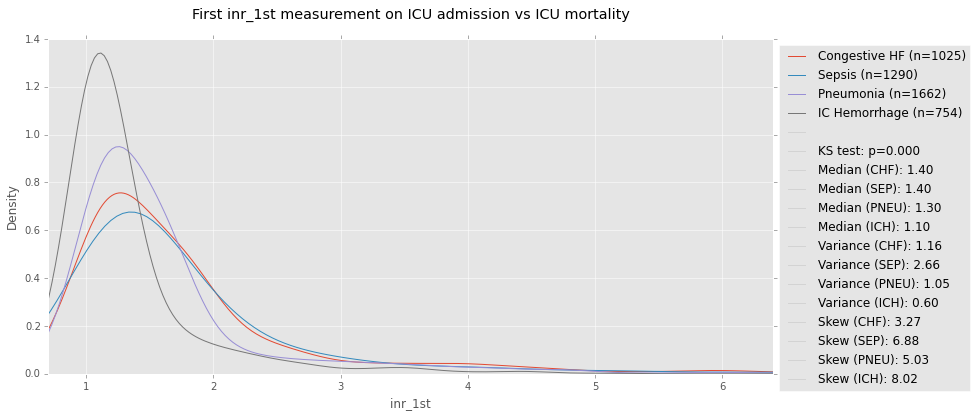

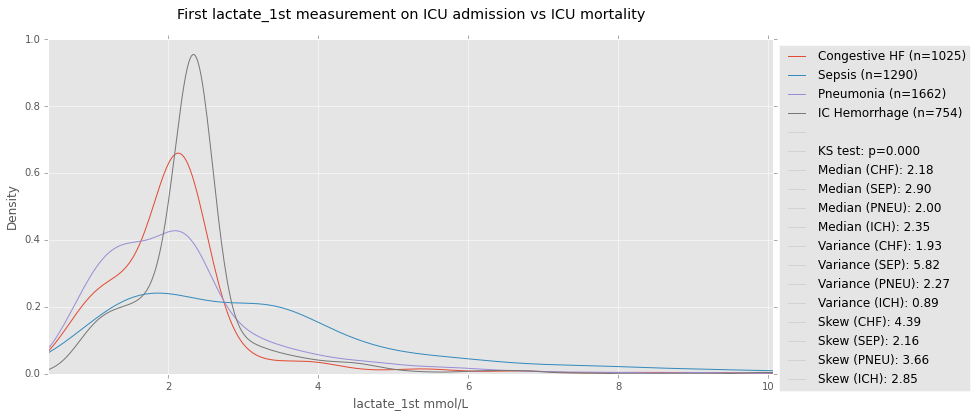

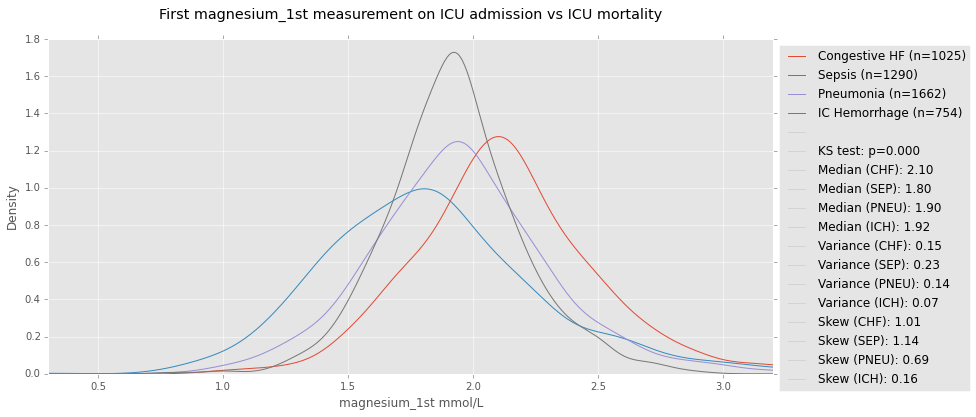

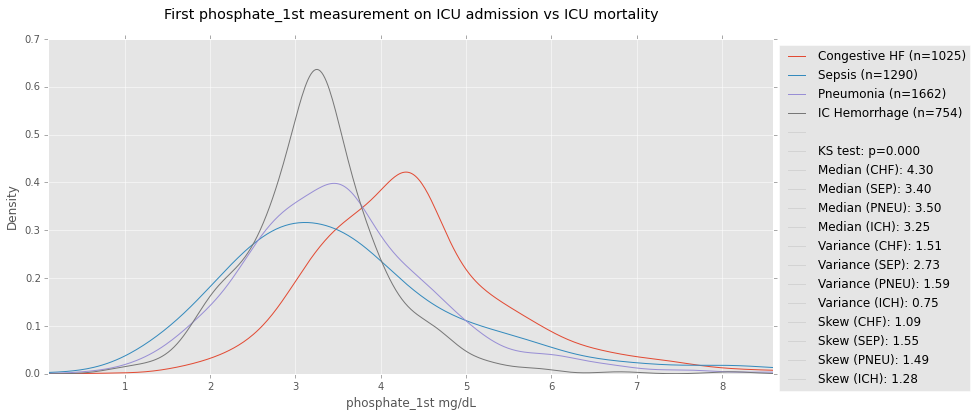

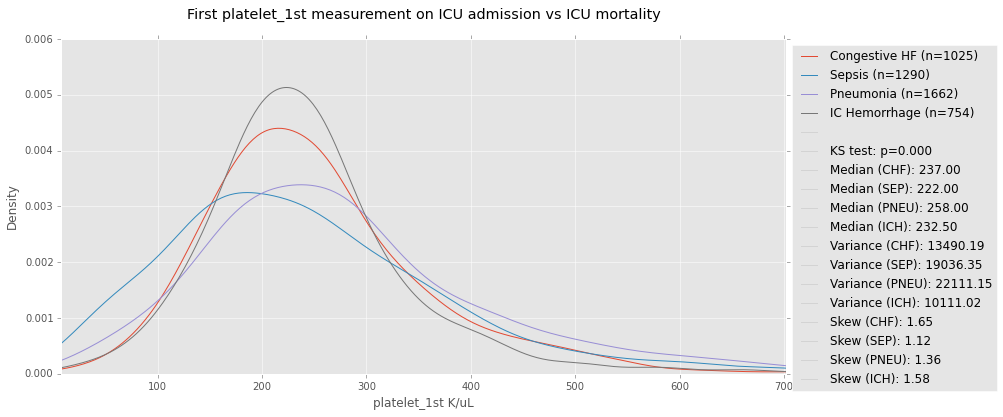

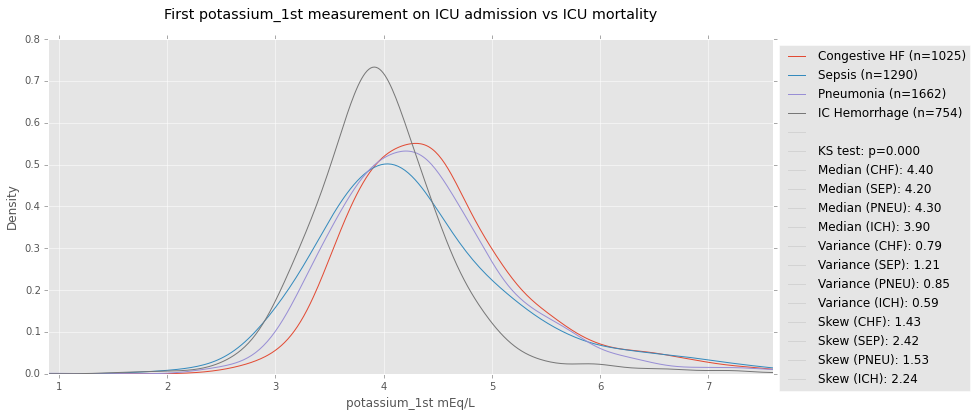

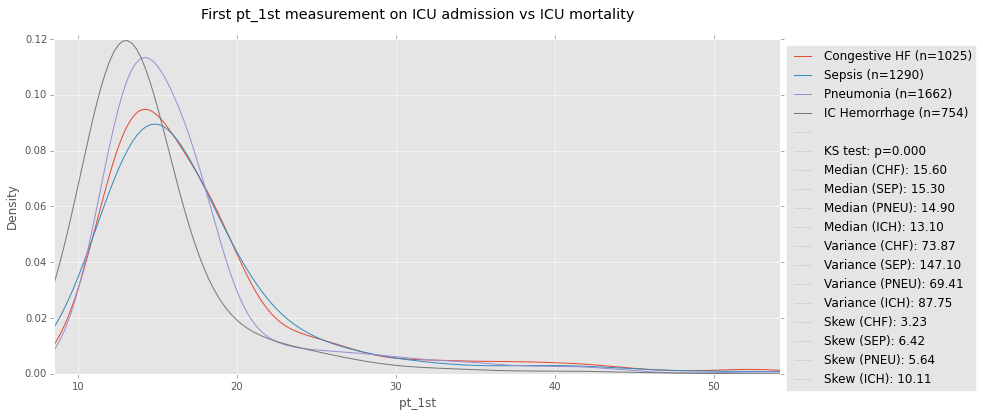

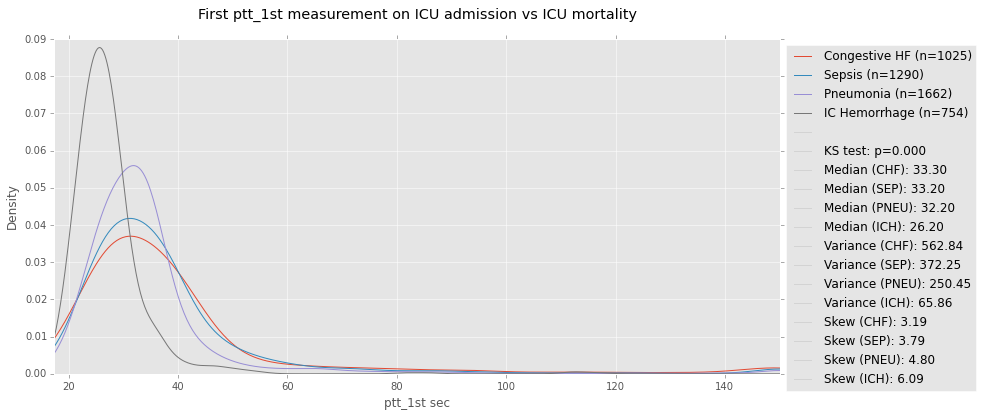

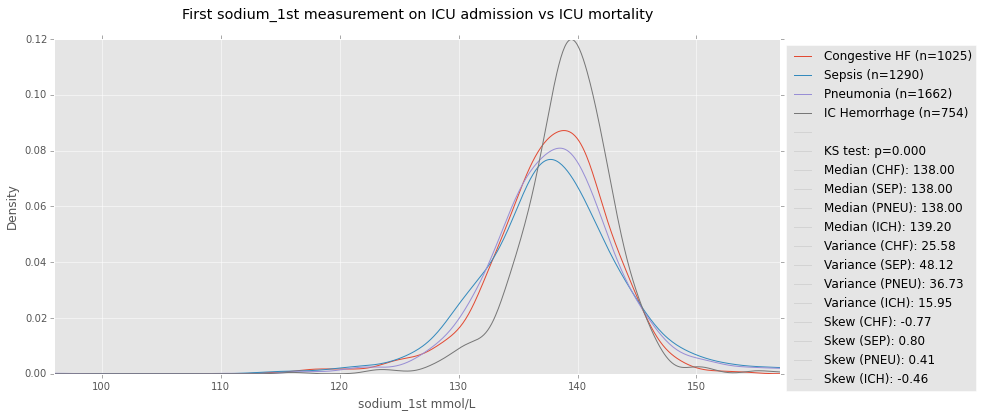

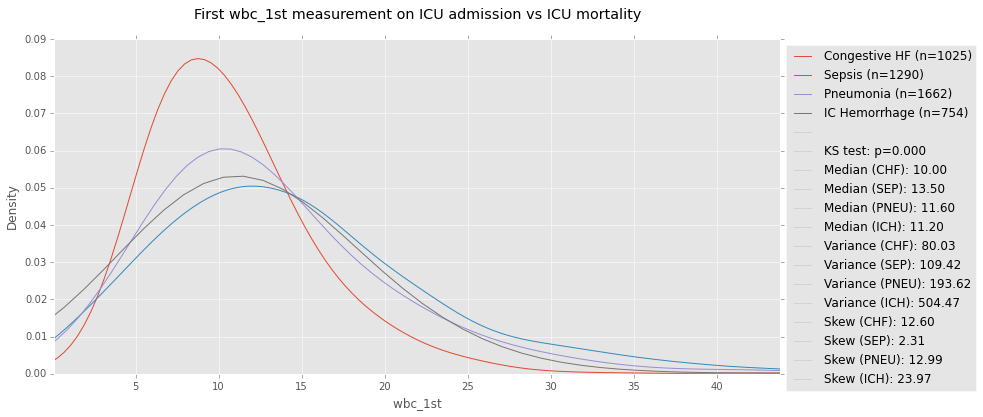

In [172]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_chf = data_imputed[l][data_imputed.diagnosis==diagnoses_list[0]].dropna().count()
    n_seps = data_imputed[l][data_imputed.diagnosis== diagnoses_list[1]].dropna().count()
    n_pneum = data_imputed[l][data_imputed.diagnosis== diagnoses_list[2]].dropna().count()
    n_ich = data_imputed[l][data_imputed.diagnosis==diagnoses_list[3]].dropna().count()
    
    # get median, variance, skewness
    med_chf = data_imputed[l][data_imputed.diagnosis==diagnoses_list[0]].dropna().median()
    med_seps = data_imputed[l][data_imputed.diagnosis== diagnoses_list[1]].dropna().median()
    med_pneum = data_imputed[l][data_imputed.diagnosis== diagnoses_list[2]].dropna().median()
    med_ich = data_imputed[l][data_imputed.diagnosis==diagnoses_list[3]].dropna().median()
    
    var_chf = data_imputed[l][data_imputed.diagnosis==diagnoses_list[0]].dropna().var()
    var_seps = data_imputed[l][data_imputed.diagnosis== diagnoses_list[1]].dropna().var()
    var_pneum = data_imputed[l][data_imputed.diagnosis== diagnoses_list[2]].dropna().var()
    var_ich = data_imputed[l][data_imputed.diagnosis==diagnoses_list[3]].dropna().var()
    
    
    skew_chf = data_imputed[l][data_imputed.diagnosis==diagnoses_list[0]].dropna().skew()
    skew_seps = data_imputed[l][data_imputed.diagnosis== diagnoses_list[1]].dropna().skew()
    skew_pneum = data_imputed[l][data_imputed.diagnosis== diagnoses_list[2]].dropna().skew()
    skew_ich = data_imputed[l][data_imputed.diagnosis==diagnoses_list[3]].dropna().skew()
    
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    # GOING TO SKIP THIS FOR TIME BEING. 
    ks_stat, p_val = (0, 0) #ks_2samp(data[l][data.mort_icu==1].dropna(),
                             # data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data_imputed[l][data_imputed.diagnosis==diagnoses_list[0]].dropna().plot.kde(
        alpha=1.0,label='Congestive HF (n={})'.format(n_chf))
    data_imputed[l][data_imputed.diagnosis== diagnoses_list[1]].dropna().plot.kde(
        alpha=1.0,label='Sepsis (n={})'.format(n_seps))
    data_imputed[l][data_imputed.diagnosis==diagnoses_list[2]].dropna().plot.kde(
        alpha=1.0,label='Pneumonia (n={})'.format(n_pneum))
    data_imputed[l][data_imputed.diagnosis== diagnoses_list[3]].dropna().plot.kde(
        alpha=1.0,label='IC Hemorrhage (n={})'.format(n_ich))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (CHF): {}'.format(format(med_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (SEP): {}'.format(format(med_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (PNEU): {}'.format(format(med_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (ICH): {}'.format(format(med_ich,'.2f')),
             color='lightgray')
    
    
    
    
    plt.plot([], label='Variance (CHF): {}'.format(format(var_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (SEP): {}'.format(format(var_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (PNEU): {}'.format(format(var_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (ICH): {}'.format(format(var_ich,'.2f')),
             color='lightgray')
    
    
    plt.plot([], label='Skew (CHF): {}'.format(format(skew_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (SEP): {}'.format(format(skew_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (PNEU): {}'.format(format(skew_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (ICH): {}'.format(format(skew_ich,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    x_min = data_imputed[l].dropna().quantile(0.00)
    x_max = data_imputed[l].dropna().quantile(0.99)
    
    # plt.xlim(-1, data_imputed[l].dropna().quantile(0.99))
    plt.xlim(x_min, x_max)
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

In [173]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data_imputed.columns[2]:
              {
             'raw_skew': scats.skew(data_imputed[data_imputed.columns[2]]), 
             'sqrt_skew': scats.skew(np.sqrt(data_imputed[data_imputed.columns[2]])), 
             'log_skew': scats.skew(np.log(data_imputed[data_imputed.columns[2]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data_imputed[data_imputed.columns[2]].add(1))[0])
             }
             }

#print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  



for col in data_imputed.columns[3:]:
    raw_skew = scats.skew(data_imputed[col])
    
    sqrt_skew = scats.skew(np.sqrt(data_imputed[col]))
    log_skew = scats.skew(np.log(data_imputed[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data_imputed[col])[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

display(skew_df)

sqrt_skew   raw_skew  boxcox_skew  log_skew
aniongap_1st      0.435703   1.128759     0.010670 -0.116821
albumin_1st      -0.669676  -0.239634     0.070096 -0.885937
bicarbonate_1st  -0.165709   0.438980     0.080776 -0.831848
bilirubin_1st     4.532436  10.799815    -0.067276  2.950120
creatinine_1st    1.751793   3.431330    -0.020385  1.302798
chloride_1st      0.207427   0.410244    -0.000849  0.010909
glucose_1st       1.562672   3.300028    -0.066499  0.442385
hematocrit_1st   -0.149074   0.224623     0.031566 -0.617107
hemoglobin_1st   -0.124665   0.199441     0.010347 -0.428155
lactate_1st       1.607480   3.191160    -0.018038  0.988858
magnesium_1st     0.198047   0.811569     0.046339  0.023578
phosphate_1st     0.525956   1.422816     0.055896  0.070248
platelet_1st      0.287793   1.407814     0.077315 -1.133053
potassium_1st     1.098382   1.949357    -0.075033  0.674352
ptt_1st           2.979843   4.117761     0.010268  1.964489
inr_1st           3.314134   6.616038     0.190627  2.441081
pt_1st            3.616663   6.478544     0.163792  2.223689
sodium_1st        0.159667   0.364943     0.008733 -0.044818
bun_1st           0.926508   1.841585     0.002350  0.153298
wbc_1st           3.325277  20.894643     0.194283 -0.099927

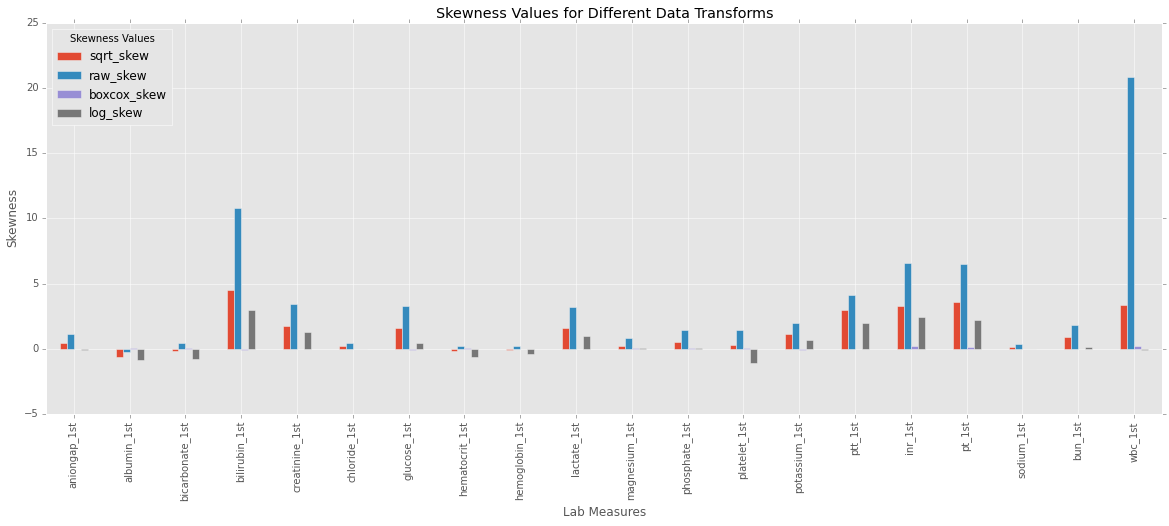

In [174]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [175]:
boxcox_data = data_imputed.copy()
for feature_name in data_imputed.columns[2:]:
    boxcox_data[feature_name] = scats.boxcox(data_imputed[feature_name])[0]

boxcox_data.head()

mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
0          0  CONGESTIVE HEART FAILURE      4.373207     3.247352   
1          0  CONGESTIVE HEART FAILURE      2.827362     3.247352   
2          0  CONGESTIVE HEART FAILURE      3.342880     3.576200   
3          1  CONGESTIVE HEART FAILURE      3.342880     3.247352   
4          0  CONGESTIVE HEART FAILURE      2.827362     3.247352   

   bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  \
0         8.000920      -0.969958        1.112746      4.439246     3.236041   
1        14.881920      -0.118610        0.000000      4.403425     3.413944   
2        12.020231      -1.297754       -0.373370      4.439246     3.226597   
3        12.391822      -0.118610       -0.545530      4.421515     3.132556   
4        13.481346      -0.118610       -0.373370      4.456634     3.191131   

   hematocrit_1st    ...     magnesium_1st  phosphate_1st  platelet_1st  \
0       13.795164    ...          0.790608       2.238031     21.750056   
1       14.566198    ...          0.916132       1.623321     21.826514   
2       17.862703    ...          0.724873       1.175442     20.435392   
3       16.494335    ...          0.656926       1.433328     16.532318   
4       13.342076    ...          0.724873       1.511683     21.673253   

   potassium_1st   ptt_1st   inr_1st    pt_1st  sodium_1st   bun_1st   wbc_1st  
0       1.228489  0.725418  0.577421  0.514285    7.034913  4.101292  4.244137  
1       1.096797  0.717328  0.159214  0.512011    7.020922  3.327833  2.909243  
2       1.140617  0.717844  0.335741  0.512853    7.020922  2.707033  2.501205  
3       1.126482  0.722435  0.623834  0.514846    7.006844  2.992607  3.631013  
4       1.048292  0.721616  0.387898  0.513584    7.048818  2.754331  1.696726  

[5 rows x 22 columns]

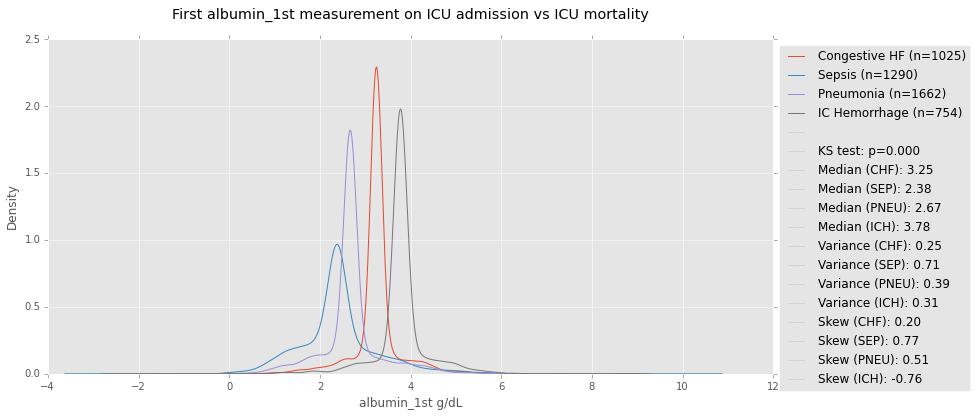

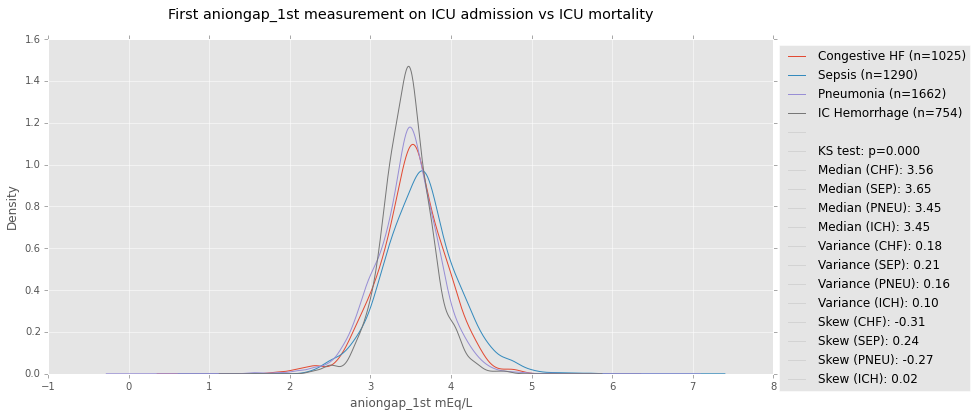

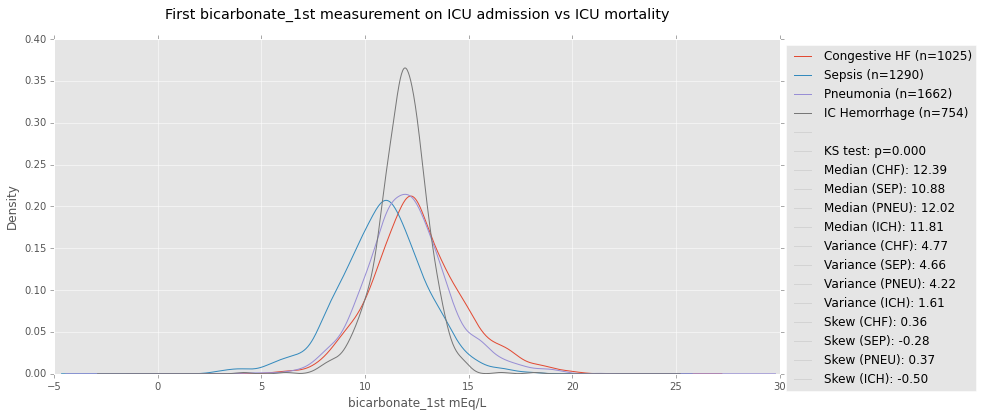

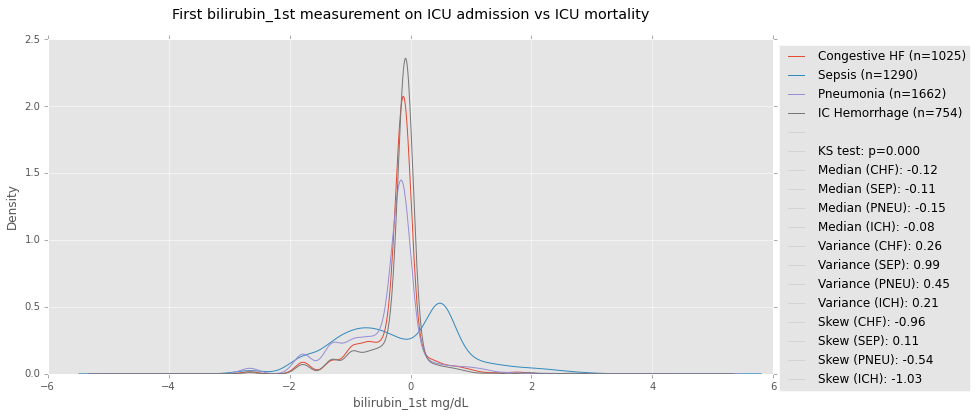

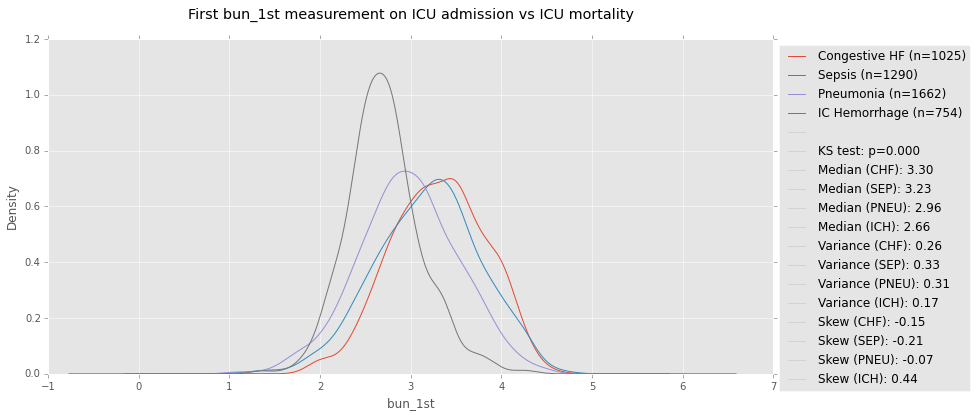

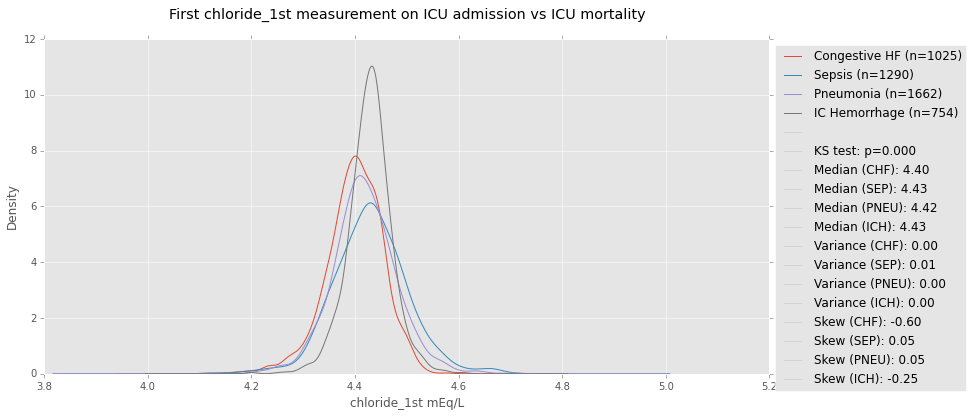

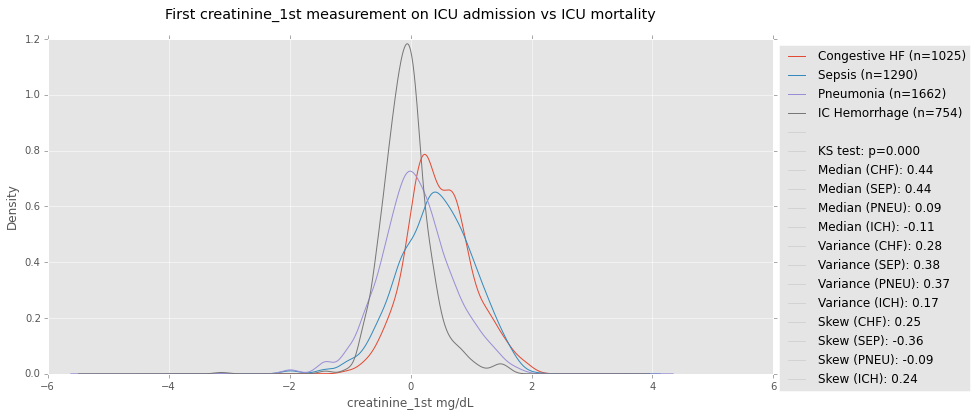

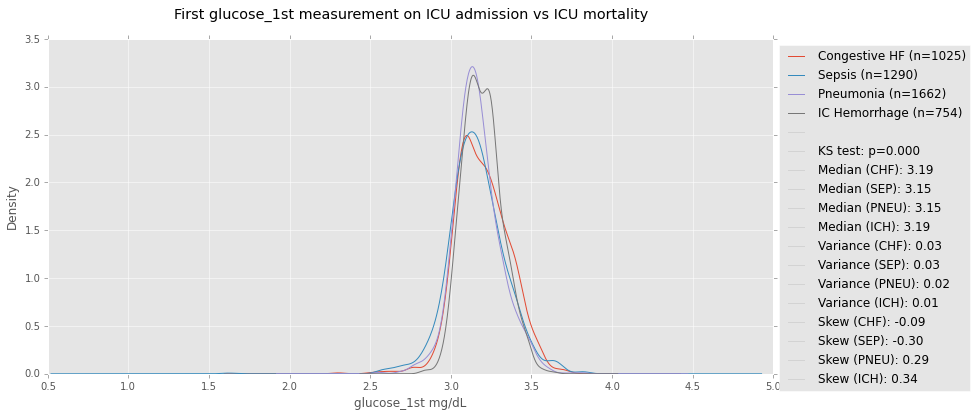

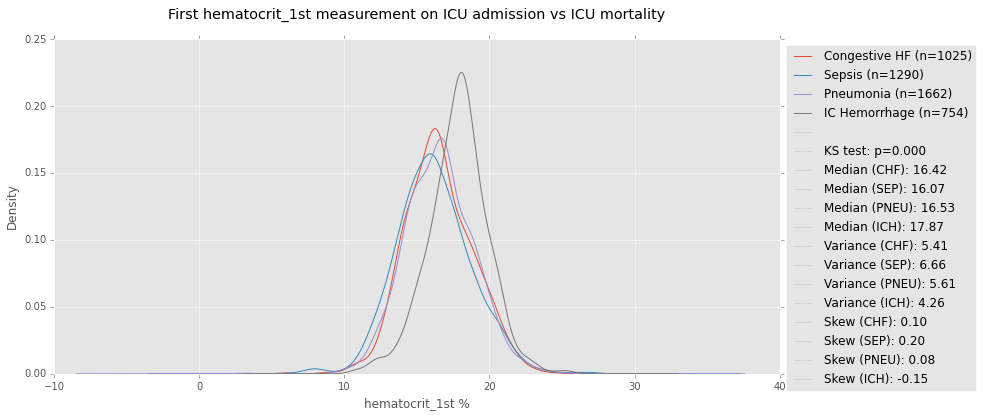

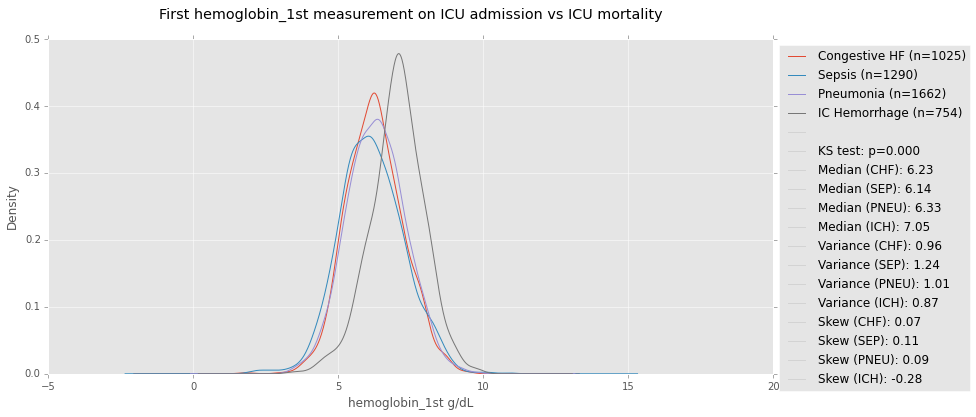

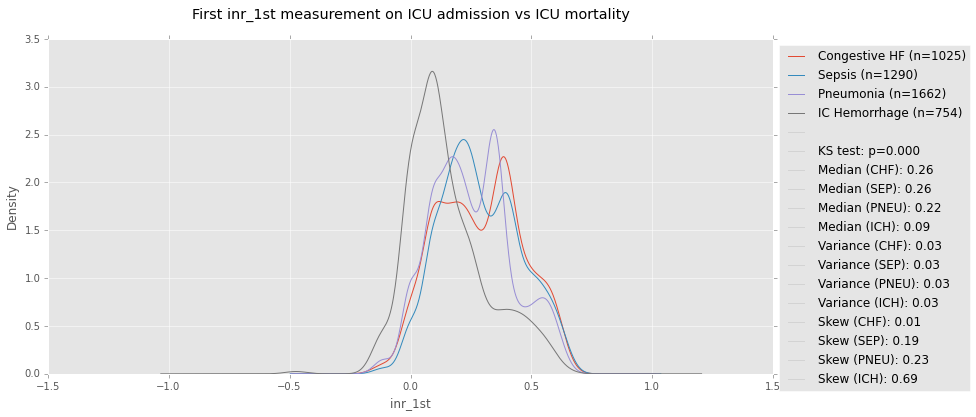

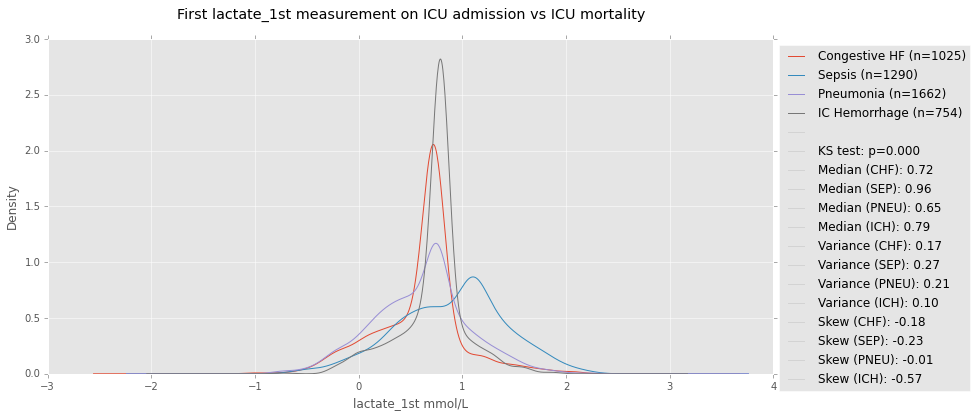

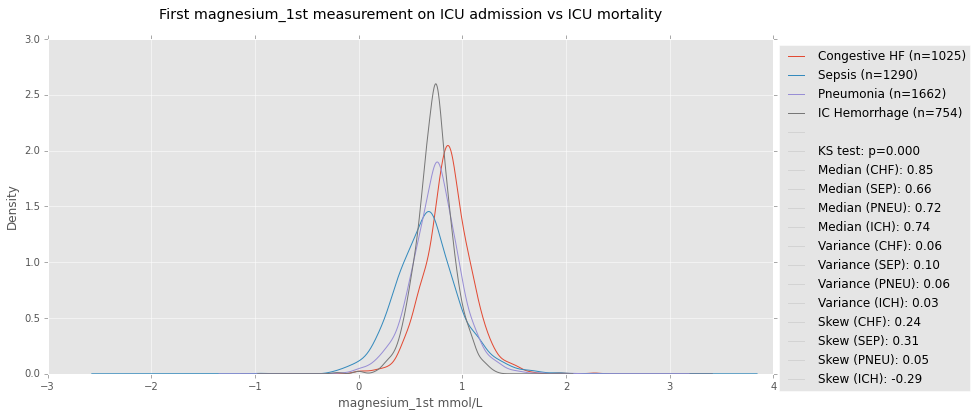

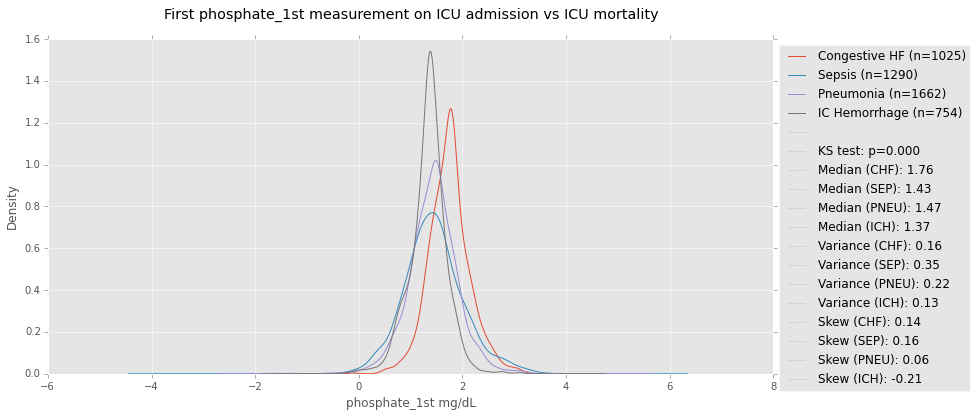

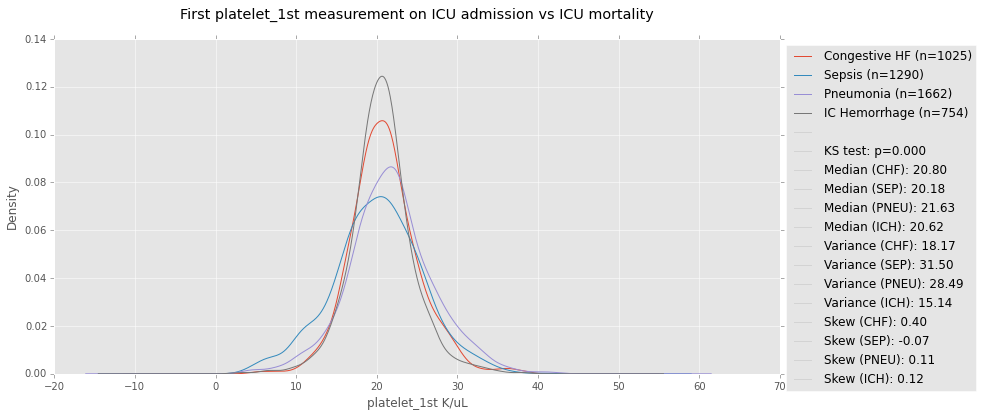

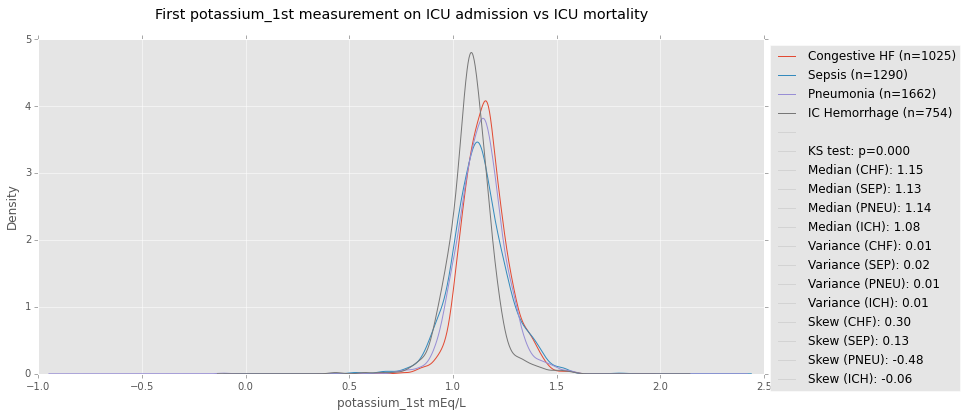

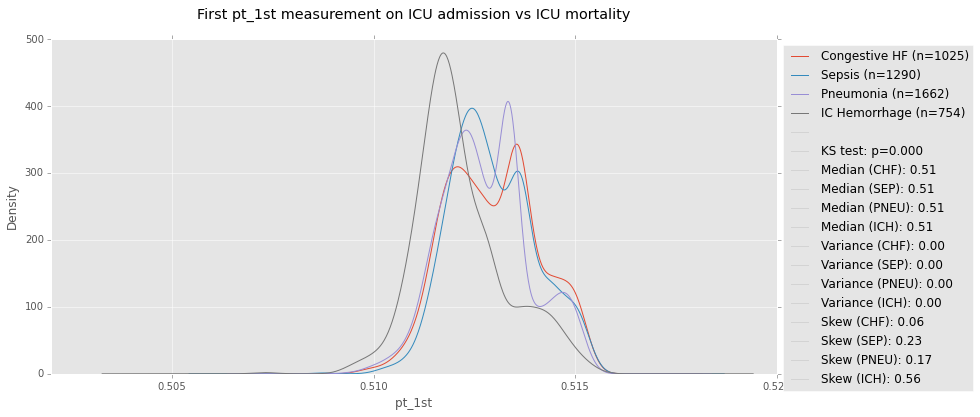

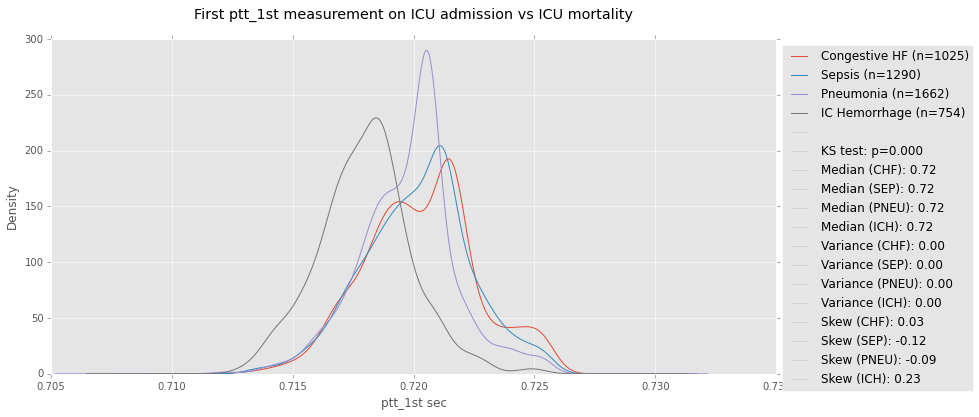

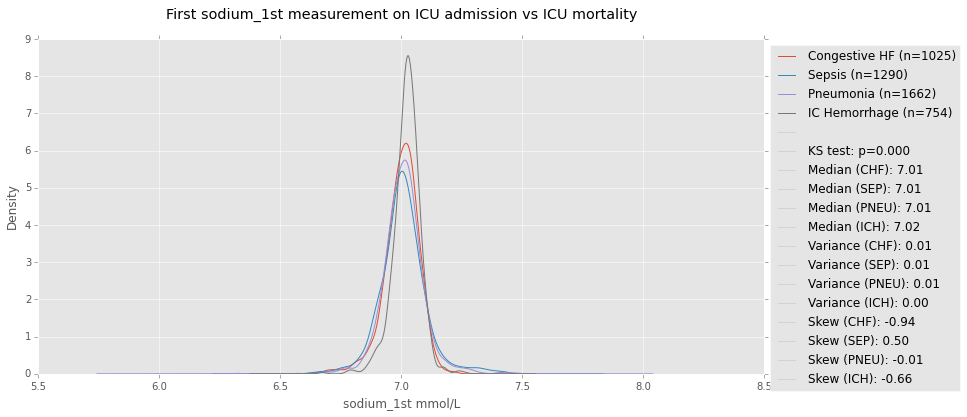

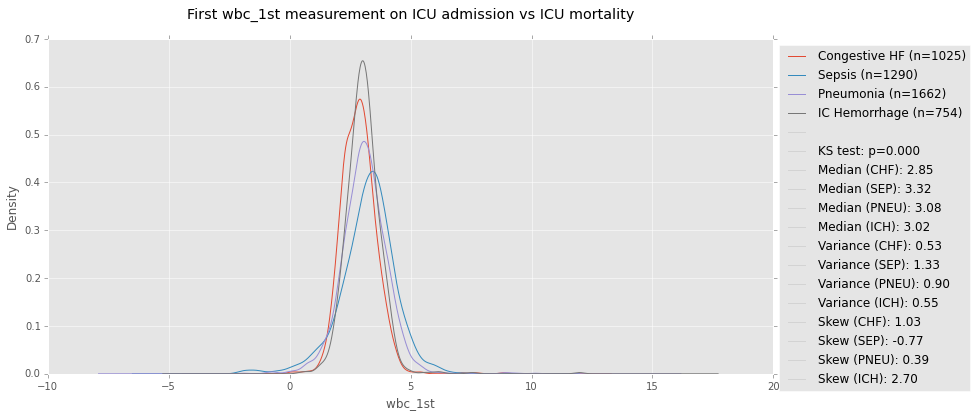

In [176]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_chf = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[0]].dropna().count()
    n_seps = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[1]].dropna().count()
    n_pneum = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[2]].dropna().count()
    n_ich = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[3]].dropna().count()
    
    # get median, variance, skewness
    med_chf = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[0]].dropna().median()
    med_seps = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[1]].dropna().median()
    med_pneum = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[2]].dropna().median()
    med_ich = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[3]].dropna().median()
    
    var_chf = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[0]].dropna().var()
    var_seps = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[1]].dropna().var()
    var_pneum = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[2]].dropna().var()
    var_ich = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[3]].dropna().var()
    
    
    skew_chf = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[0]].dropna().skew()
    skew_seps = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[1]].dropna().skew()
    skew_pneum = boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[2]].dropna().skew()
    skew_ich = boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[3]].dropna().skew()
    
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    # GOING TO SKIP THIS FOR TIME BEING. 
    ks_stat, p_val = (0, 0) #ks_2samp(data[l][data.mort_icu==1].dropna(),
                             # data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[0]].dropna().plot.kde(
        alpha=1.0,label='Congestive HF (n={})'.format(n_chf))
    boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[1]].dropna().plot.kde(
        alpha=1.0,label='Sepsis (n={})'.format(n_seps))
    boxcox_data[l][boxcox_data.diagnosis==diagnoses_list[2]].dropna().plot.kde(
        alpha=1.0,label='Pneumonia (n={})'.format(n_pneum))
    boxcox_data[l][boxcox_data.diagnosis== diagnoses_list[3]].dropna().plot.kde(
        alpha=1.0,label='IC Hemorrhage (n={})'.format(n_ich))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (CHF): {}'.format(format(med_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (SEP): {}'.format(format(med_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (PNEU): {}'.format(format(med_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (ICH): {}'.format(format(med_ich,'.2f')),
             color='lightgray')
    
    
    
    
    plt.plot([], label='Variance (CHF): {}'.format(format(var_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (SEP): {}'.format(format(var_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (PNEU): {}'.format(format(var_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (ICH): {}'.format(format(var_ich,'.2f')),
             color='lightgray')
    
    
    plt.plot([], label='Skew (CHF): {}'.format(format(skew_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (SEP): {}'.format(format(skew_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (PNEU): {}'.format(format(skew_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (ICH): {}'.format(format(skew_ich,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

In [177]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.columns[2:]:
    #if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

In [178]:
display(names_dict)

{'albumin_1st_outliers': Int64Index([  26,   55,   66,   73,   75,  134,  244,  263,  273,  371,
             ...
             4630, 4632, 4634, 4635, 4673, 4675, 4691, 4694, 4714, 4723],
            dtype='int64', length=238),
 'aniongap_1st_outliers': Int64Index([  56,  147,  161,  166,  167,  187,  259,  264,  322,  380,  389,
              390,  415,  513,  595,  678,  715,  727,  729,  867,  873,  886,
              889,  909, 1054, 1073, 1089, 1167, 1216, 1223, 1266, 1323, 1380,
             1404, 1424, 1478, 1496, 1541, 1568, 1581, 1611, 1647, 1699, 1713,
             1751, 1769, 1772, 1780, 1804, 1862, 1875, 1905, 1939, 2016, 2048,
             2074, 2080, 2091, 2119, 2123, 2153, 2196, 2198, 2199, 2211, 2285,
             2318, 2333, 2336, 2401, 2477, 2486, 2501, 2519, 2548, 2601, 2625,
             2705, 2842, 2904, 2974, 2981, 2987, 3036, 3089, 3146, 3179, 3415,
             3416, 3458, 3606, 3732, 3820, 4034, 4339, 4481, 4649],
            dtype='int64'),
 'bicarbonate_1st_o

In [179]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts > 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

the total outlier indices = 2739
the following data points have >2 outlying feature and will be removed: 
[56, 141, 147, 161, 166, 167, 187, 256, 259, 264, 278, 410, 513, 678, 715, 729, 795, 841, 909, 916, 924, 982, 989, 992, 1032, 1054, 1057, 1061, 1073, 1079, 1080, 1089, 1111, 1124, 1125, 1134, 1167, 1173, 1203, 1205, 1208, 1212, 1215, 1216, 1223, 1229, 1240, 1257, 1260, 1266, 1271, 1275, 1286, 1294, 1320, 1327, 1337, 1345, 1361, 1368, 1380, 1381, 1385, 1389, 1395, 1404, 1405, 1407, 1426, 1431, 1438, 1451, 1478, 1496, 1505, 1507, 1519, 1523, 1525, 1526, 1540, 1541, 1554, 1581, 1608, 1611, 1619, 1623, 1647, 1673, 1677, 1687, 1696, 1699, 1701, 1713, 1729, 1733, 1751, 1769, 1770, 1772, 1799, 1804, 1810, 1826, 1862, 1863, 1875, 1887, 1889, 1905, 1906, 1931, 1936, 1939, 1940, 1944, 1950, 1958, 1973, 1985, 1998, 2016, 2017, 2043, 2046, 2048, 2056, 2062, 2063, 2066, 2074, 2080, 2086, 2091, 2103, 2107, 2123, 2142, 2143, 2148, 2153, 2181, 2188, 2196, 2198, 2199, 2205, 2211, 2214, 2224, 2242, 

In [180]:
boxcox_data2

(4489, 22)

In [181]:
# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[2:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data2.head())



mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
0          0  CONGESTIVE HEART FAILURE      2.282388     0.394330   
1          0  CONGESTIVE HEART FAILURE     -1.760068     0.394330   
2          0  CONGESTIVE HEART FAILURE     -0.411964     0.812043   
3          1  CONGESTIVE HEART FAILURE     -0.411964     0.394330   
4          0  CONGESTIVE HEART FAILURE     -1.760068     0.394330   

   bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  \
0        -1.986864      -1.004983        1.511783      0.349218     0.389562   
1         1.564361       0.246628       -0.388295     -0.272167     1.585488   
2         0.087468      -1.486893       -1.025846      0.349218     0.326075   
3         0.279243       0.246628       -1.319818      0.041632    -0.306099   
4         0.841537       0.246628       -1.025846      0.650831     0.087661   

   hematocrit_1st    ...     magnesium_1st  phosphate_1st  platelet_1st  \
0       -1.222954    ...          0.178109       1.639133      0.154151   
1       -0.893947    ...          0.672924       0.312822      0.169937   
2        0.512699    ...         -0.081021      -0.653529     -0.117286   
3       -0.071195    ...         -0.348869      -0.097108     -0.923150   
4       -1.416290    ...         -0.081021       0.071951      0.138294   

   potassium_1st   ptt_1st   inr_1st    pt_1st  sodium_1st   bun_1st   wbc_1st  
0       0.863563  2.552678  1.895134  1.369656    0.341384  1.894671  1.325481  
1      -0.288352 -1.052333 -0.535269 -0.666277    0.154873  0.499999 -0.168716  
2       0.094944 -0.822513  0.490614  0.087572    0.154873 -0.619404 -0.625449  
3      -0.028696  1.223412  2.164862  1.871562   -0.032801 -0.104468  0.639189  
4      -0.712629  0.858629  0.793723  0.741778    0.526747 -0.534118 -1.525933  

[5 rows x 22 columns]

mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
0          0  CONGESTIVE HEART FAILURE      4.373207     3.247352   
1          0  CONGESTIVE HEART FAILURE      2.827362     3.247352   
2          0  CONGESTIVE HEART FAILURE      3.342880     3.576200   
3          1  CONGESTIVE HEART FAILURE      3.342880     3.247352   
4          0  CONGESTIVE HEART FAILURE      2.827362     3.247352   

   bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  \
0         8.000920      -0.969958        1.112746      4.439246     3.236041   
1        14.881920      -0.118610        0.000000      4.403425     3.413944   
2        12.020231      -1.297754       -0.373370      4.439246     3.226597   
3        12.391822      -0.118610       -0.545530      4.421515     3.132556   
4        13.481346      -0.118610       -0.373370      4.456634     3.191131   

   hematocrit_1st    ...     magnesium_1st  phosphate_1st  platelet_1st  \
0       13.795164    ...          0.790608       2.238031     21.750056   
1       14.566198    ...          0.916132       1.623321     21.826514   
2       17.862703    ...          0.724873       1.175442     20.435392   
3       16.494335    ...          0.656926       1.433328     16.532318   
4       13.342076    ...          0.724873       1.511683     21.673253   

   potassium_1st   ptt_1st   inr_1st    pt_1st  sodium_1st   bun_1st   wbc_1st  
0       1.228489  0.725418  0.577421  0.514285    7.034913  4.101292  4.244137  
1       1.096797  0.717328  0.159214  0.512011    7.020922  3.327833  2.909243  
2       1.140617  0.717844  0.335741  0.512853    7.020922  2.707033  2.501205  
3       1.126482  0.722435  0.623834  0.514846    7.006844  2.992607  3.631013  
4       1.048292  0.721616  0.387898  0.513584    7.048818  2.754331  1.696726  

[5 rows x 22 columns]

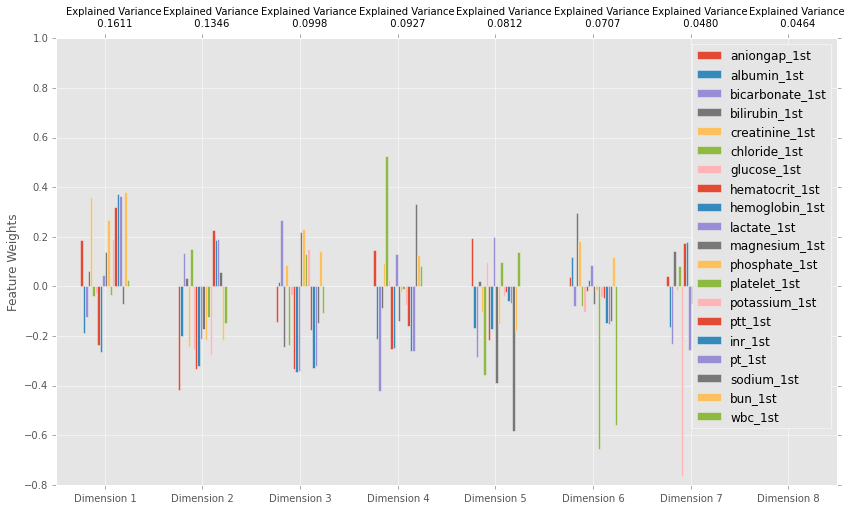

In [184]:
pca = PCA(n_components = 8).fit(boxcox_data_scaled[boxcox_data_scaled.columns[2:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[2:]], pca)



In [185]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[2:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 
                                                    'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0     5.009303    -0.979436    -0.569606     1.153963     0.147870   
1    -0.793342     0.429639     2.004199    -0.207995    -0.580957   
2    -1.458517     0.124325    -0.374257    -0.367915    -0.411657   
3     1.104910     2.053110    -1.312627    -1.741181    -0.526597   
4     0.199209     2.984804     0.315779    -0.297930    -0.702956   

   Dimension 6  Dimension 7  Dimension 8  
0    -1.170332    -0.055004    -1.221528  
1    -0.074214    -2.103216     1.314774  
2    -0.305836    -0.641800    -1.566581  
3    -0.656654     0.199422    -0.280942  
4     0.129334    -1.178579     0.048177

In [186]:
boxcox_data_scaled.head()

mort_hosp                 diagnosis  aniongap_1st  albumin_1st  \
0          0  CONGESTIVE HEART FAILURE      2.282388     0.394330   
1          0  CONGESTIVE HEART FAILURE     -1.760068     0.394330   
2          0  CONGESTIVE HEART FAILURE     -0.411964     0.812043   
3          1  CONGESTIVE HEART FAILURE     -0.411964     0.394330   
4          0  CONGESTIVE HEART FAILURE     -1.760068     0.394330   

   bicarbonate_1st  bilirubin_1st  creatinine_1st  chloride_1st  glucose_1st  \
0        -1.986864      -1.004983        1.511783      0.349218     0.389562   
1         1.564361       0.246628       -0.388295     -0.272167     1.585488   
2         0.087468      -1.486893       -1.025846      0.349218     0.326075   
3         0.279243       0.246628       -1.319818      0.041632    -0.306099   
4         0.841537       0.246628       -1.025846      0.650831     0.087661   

   hematocrit_1st    ...     magnesium_1st  phosphate_1st  platelet_1st  \
0       -1.222954    ...          0.178109       1.639133      0.154151   
1       -0.893947    ...          0.672924       0.312822      0.169937   
2        0.512699    ...         -0.081021      -0.653529     -0.117286   
3       -0.071195    ...         -0.348869      -0.097108     -0.923150   
4       -1.416290    ...         -0.081021       0.071951      0.138294   

   potassium_1st   ptt_1st   inr_1st    pt_1st  sodium_1st   bun_1st   wbc_1st  
0       0.863563  2.552678  1.895134  1.369656    0.341384  1.894671  1.325481  
1      -0.288352 -1.052333 -0.535269 -0.666277    0.154873  0.499999 -0.168716  
2       0.094944 -0.822513  0.490614  0.087572    0.154873 -0.619404 -0.625449  
3      -0.028696  1.223412  2.164862  1.871562   -0.032801 -0.104468  0.639189  
4      -0.712629  0.858629  0.793723  0.741778    0.526747 -0.534118 -1.525933  

[5 rows x 22 columns]

In [216]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(boxcox_data_scaled['diagnosis']) 
targets[3000:3010]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [217]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, targets, 
                                                    test_size = 0.40, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, reduced_data, targets, cv=5)
display(scores)  



array([ 0.60111111,  0.57349666,  0.57461024,  0.58416945,  0.5859375 ])

In [196]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, targets,
                                                    test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




0.35337787676317745

array([[  0,   0, 300,   0],
       [  0,   0, 205,   0],
       [  0,   0, 476,   0],
       [  0,   0, 366,   0]])

In [199]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, targets, test_size = 0.20, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.559020044543


array([[111,  23,  52,  14],
       [ 15,  92,  22,   6],
       [ 50,  47, 179,  50],
       [ 21,  10,  86, 120]])

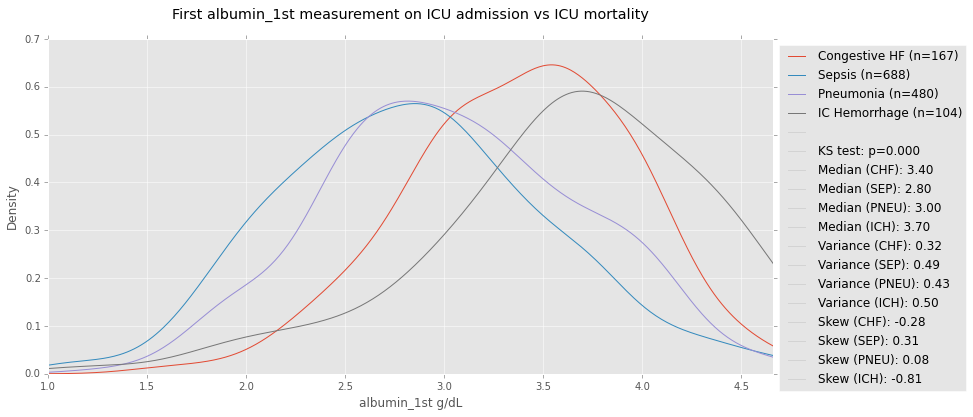

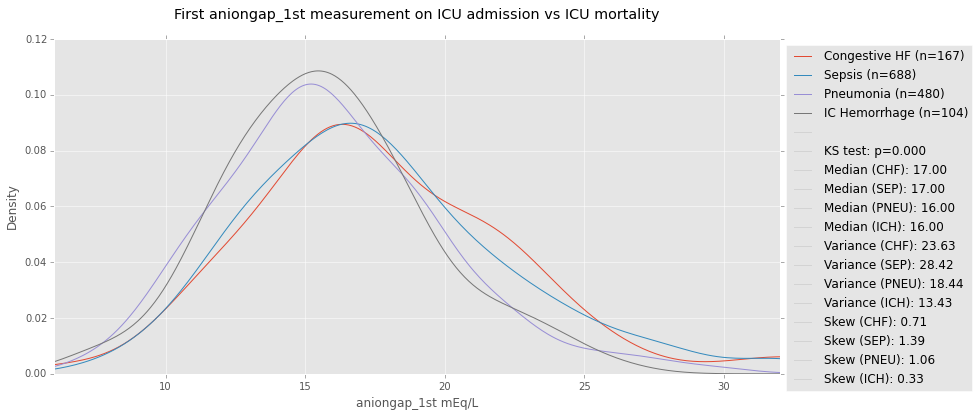

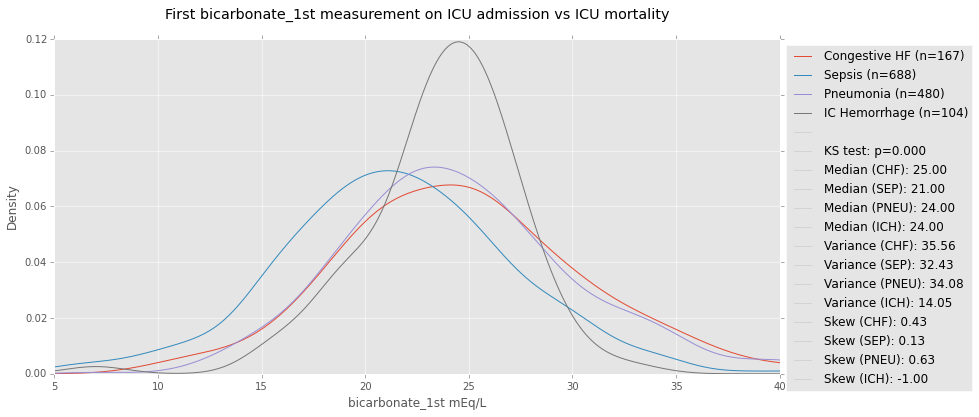

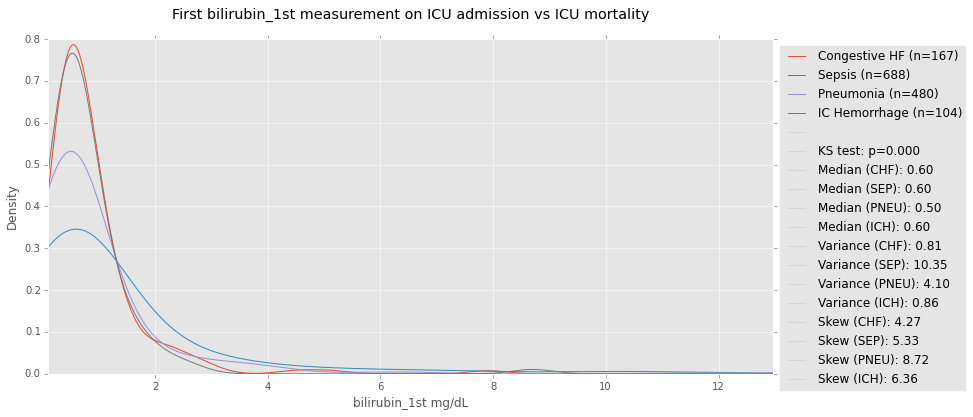

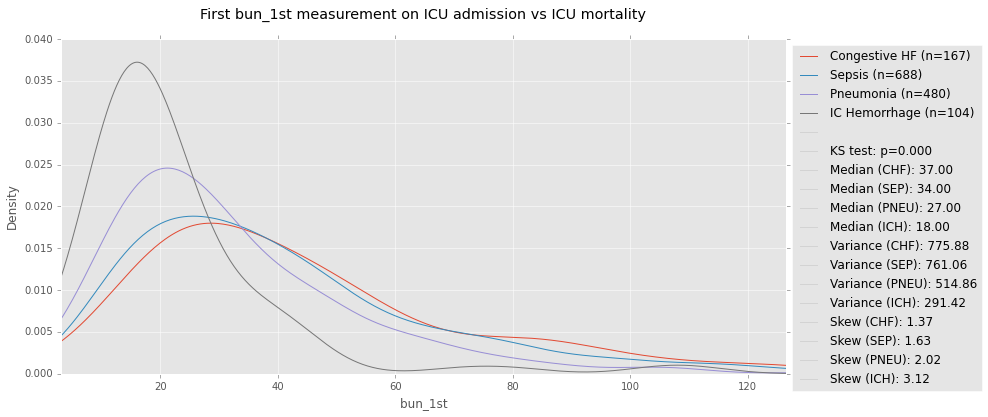

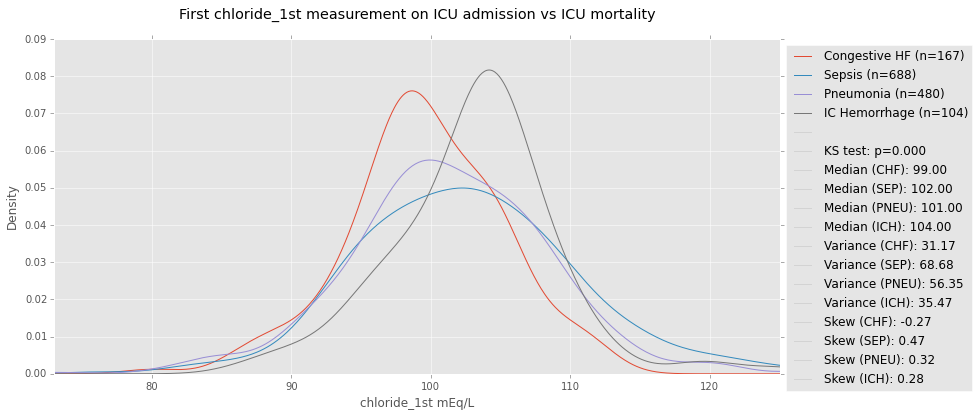

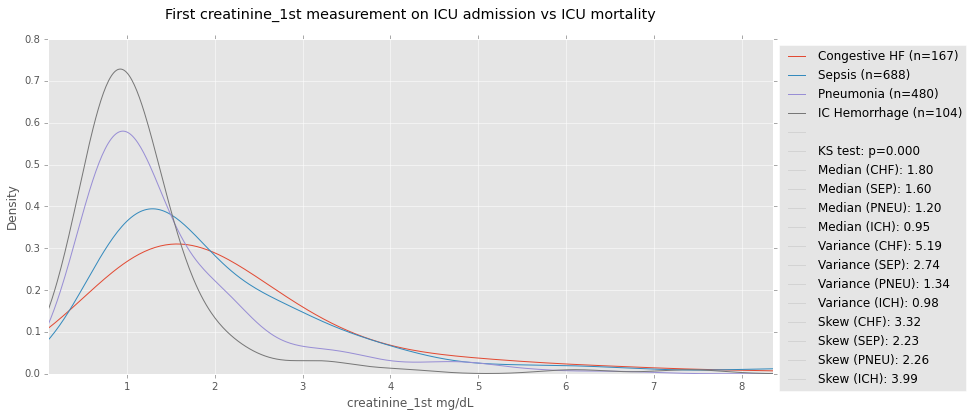

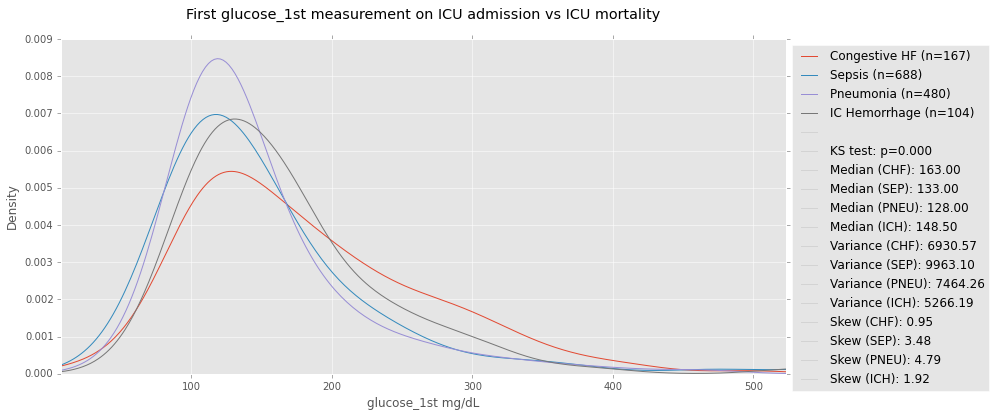

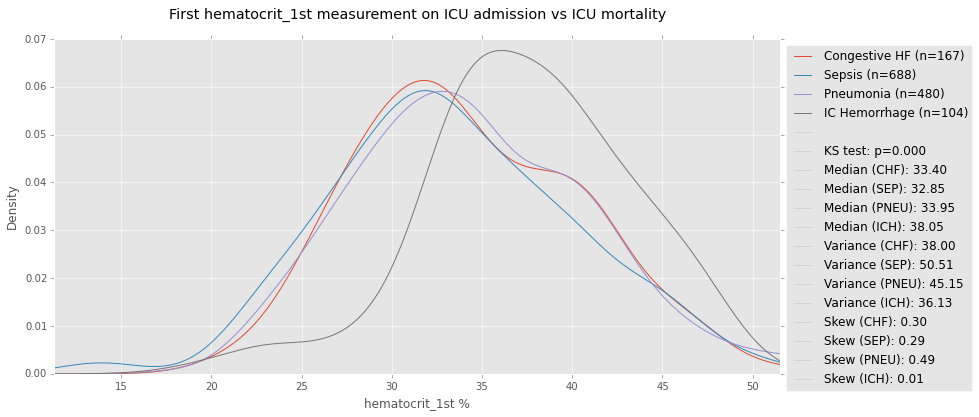

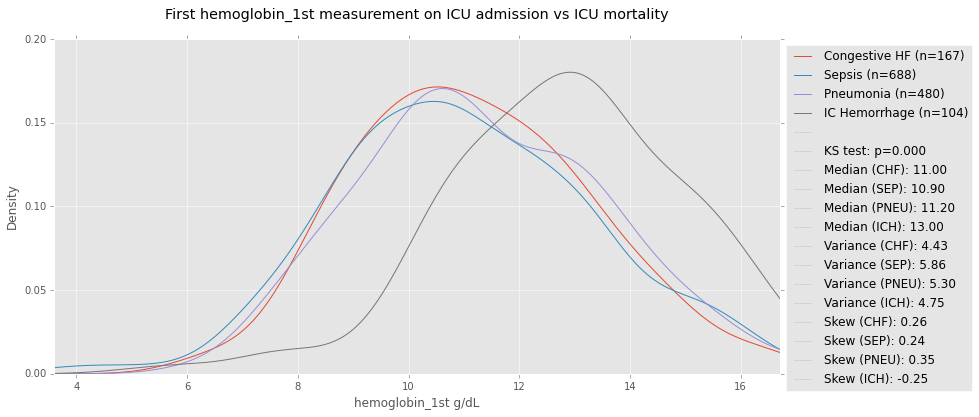

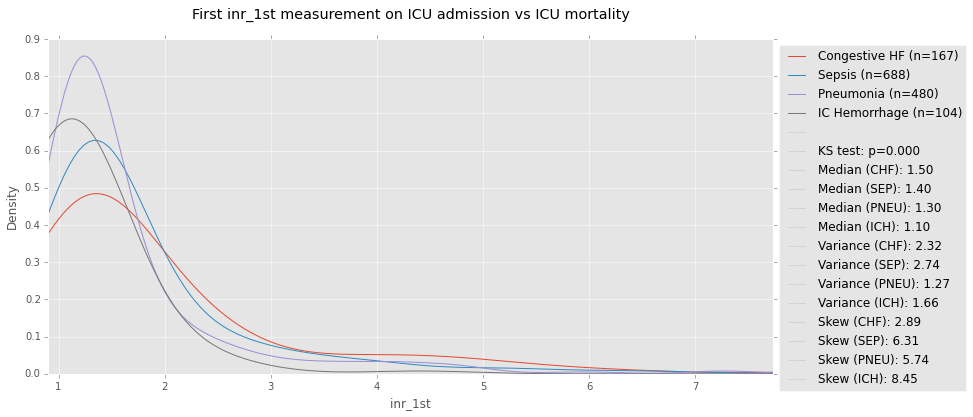

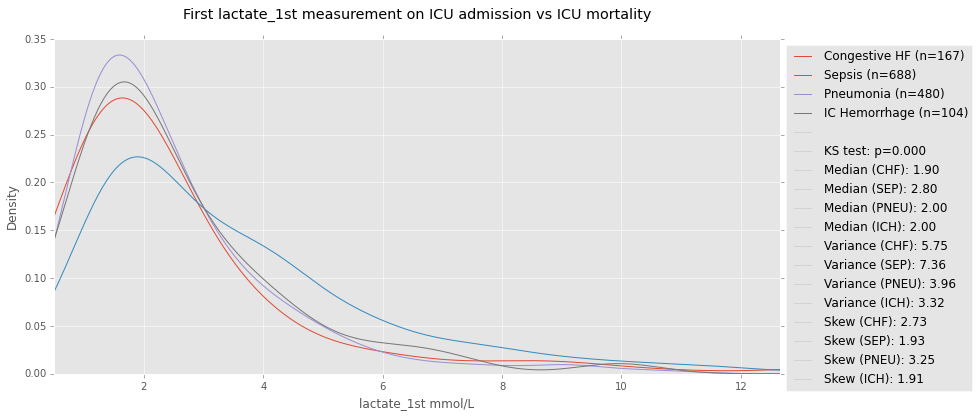

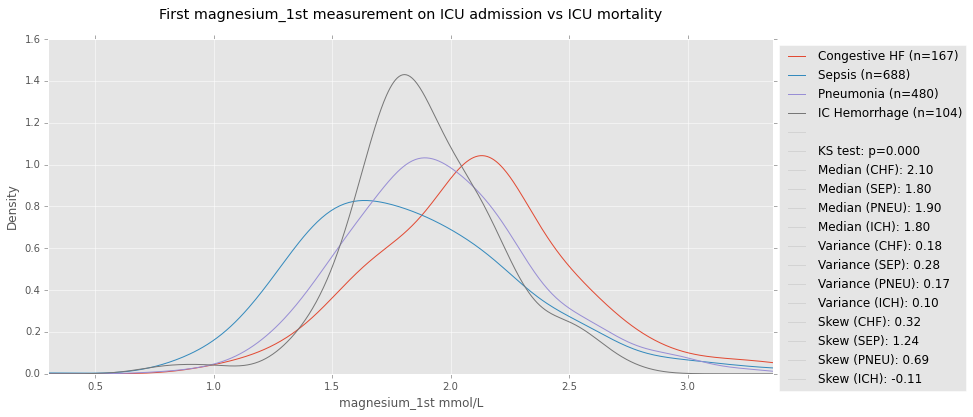

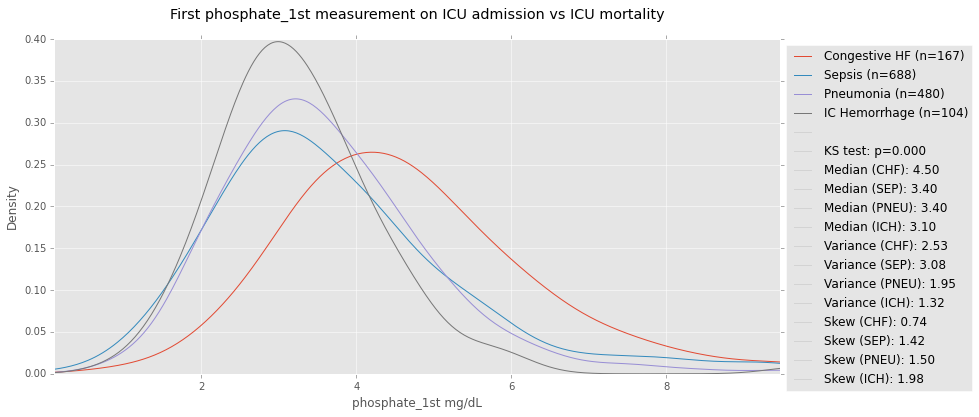

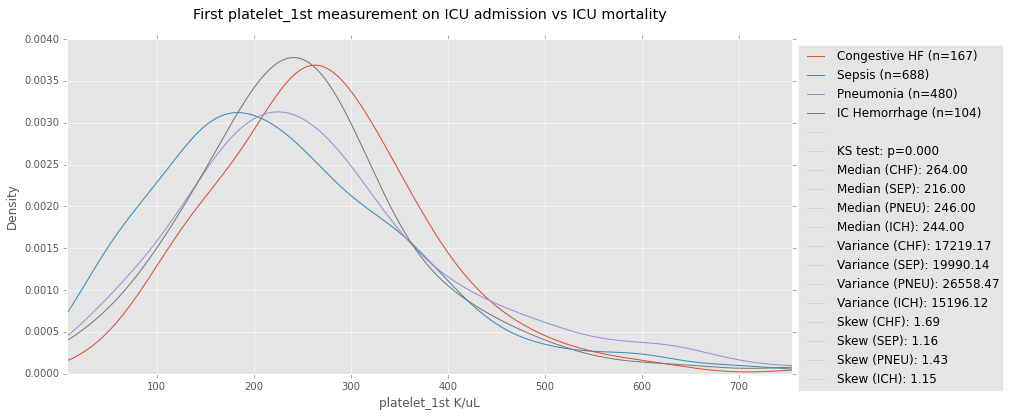

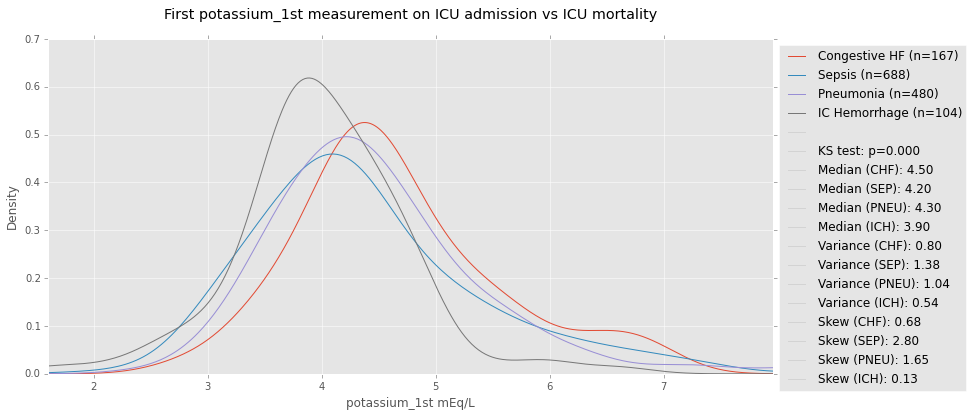

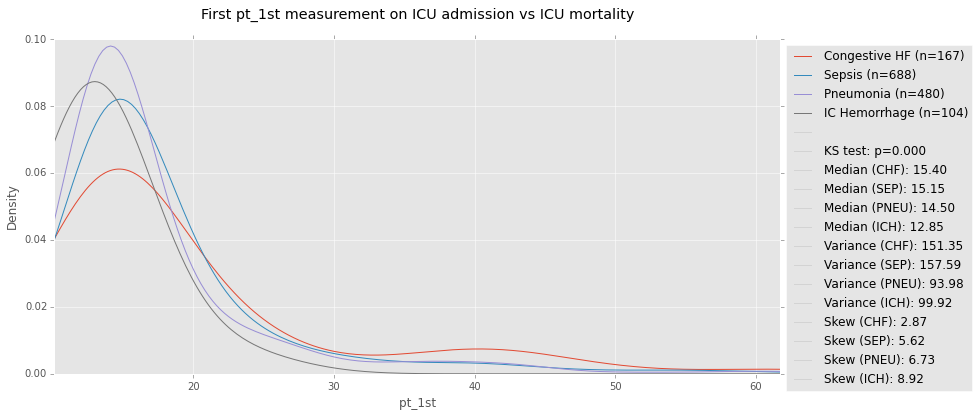

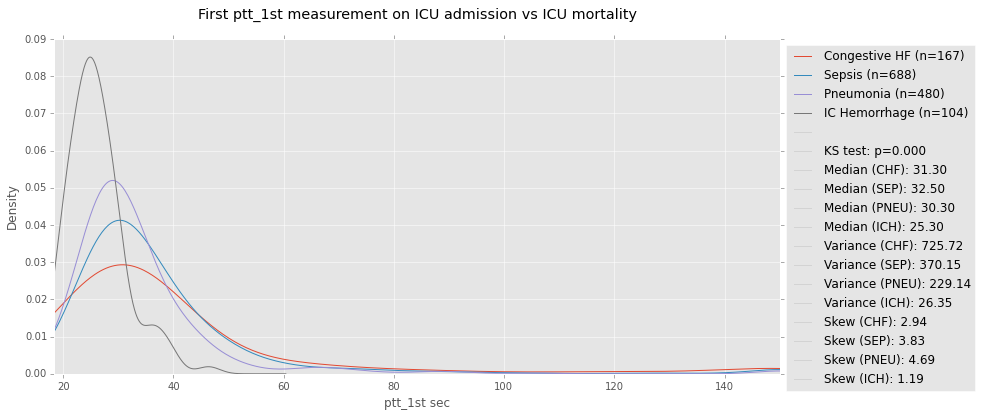

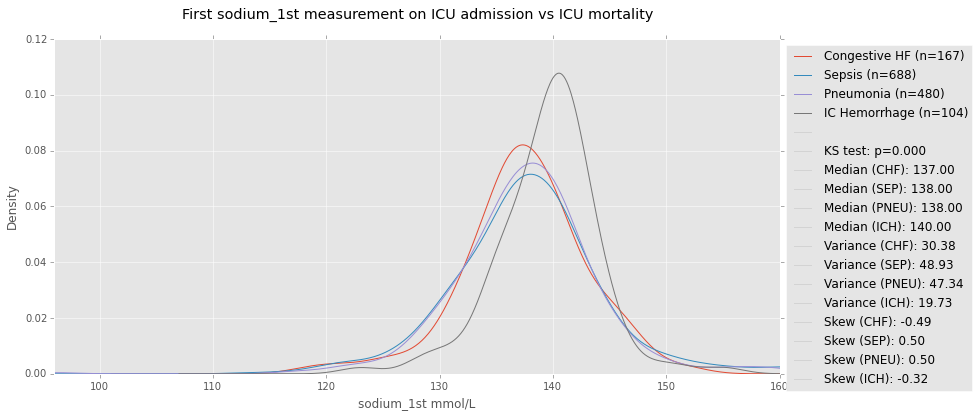

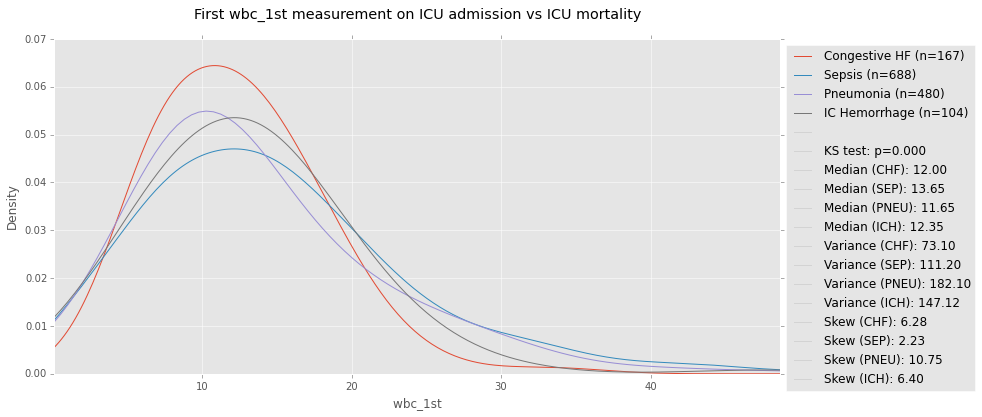

In [213]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_chf = lab_results2[l][lab_results2.diagnosis==diagnoses_list[0]].dropna().count()
    n_seps = lab_results2[l][lab_results2.diagnosis== diagnoses_list[1]].dropna().count()
    n_pneum = lab_results2[l][lab_results2.diagnosis== diagnoses_list[2]].dropna().count()
    n_ich = lab_results2[l][lab_results2.diagnosis==diagnoses_list[3]].dropna().count()
    
    # get median, variance, skewness
    med_chf = lab_results2[l][lab_results2.diagnosis==diagnoses_list[0]].dropna().median()
    med_seps = lab_results2[l][lab_results2.diagnosis== diagnoses_list[1]].dropna().median()
    med_pneum = lab_results2[l][lab_results2.diagnosis== diagnoses_list[2]].dropna().median()
    med_ich = lab_results2[l][lab_results2.diagnosis==diagnoses_list[3]].dropna().median()
    
    var_chf = lab_results2[l][lab_results2.diagnosis==diagnoses_list[0]].dropna().var()
    var_seps = lab_results2[l][lab_results2.diagnosis== diagnoses_list[1]].dropna().var()
    var_pneum = lab_results2[l][lab_results2.diagnosis== diagnoses_list[2]].dropna().var()
    var_ich = lab_results2[l][lab_results2.diagnosis==diagnoses_list[3]].dropna().var()
    
    
    skew_chf = lab_results2[l][lab_results2.diagnosis==diagnoses_list[0]].dropna().skew()
    skew_seps = lab_results2[l][lab_results2.diagnosis== diagnoses_list[1]].dropna().skew()
    skew_pneum = lab_results2[l][lab_results2.diagnosis== diagnoses_list[2]].dropna().skew()
    skew_ich = lab_results2[l][lab_results2.diagnosis==diagnoses_list[3]].dropna().skew()
    
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    # GOING TO SKIP THIS FOR TIME BEING. 
    ks_stat, p_val = (0, 0) #ks_2samp(data[l][data.mort_icu==1].dropna(),
                             # data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    lab_results2[l][lab_results2.diagnosis==diagnoses_list[0]].dropna().plot.kde(
        alpha=1.0,label='Congestive HF (n={})'.format(n_chf))
    lab_results2[l][lab_results2.diagnosis== diagnoses_list[1]].dropna().plot.kde(
        alpha=1.0,label='Sepsis (n={})'.format(n_seps))
    lab_results2[l][lab_results2.diagnosis==diagnoses_list[2]].dropna().plot.kde(
        alpha=1.0,label='Pneumonia (n={})'.format(n_pneum))
    lab_results2[l][lab_results2.diagnosis== diagnoses_list[3]].dropna().plot.kde(
        alpha=1.0,label='IC Hemorrhage (n={})'.format(n_ich))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (CHF): {}'.format(format(med_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (SEP): {}'.format(format(med_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (PNEU): {}'.format(format(med_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (ICH): {}'.format(format(med_ich,'.2f')),
             color='lightgray')
    
    
    
    
    plt.plot([], label='Variance (CHF): {}'.format(format(var_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (SEP): {}'.format(format(var_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (PNEU): {}'.format(format(var_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (ICH): {}'.format(format(var_ich,'.2f')),
             color='lightgray')
    
    
    plt.plot([], label='Skew (CHF): {}'.format(format(skew_chf,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (SEP): {}'.format(format(skew_seps,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (PNEU): {}'.format(format(skew_pneum,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (ICH): {}'.format(format(skew_ich,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    x_min = lab_results2[l].dropna().quantile(0.00)
    x_max = lab_results2[l].dropna().quantile(0.99)
    
    # plt.xlim(-1, lab_results2[l].dropna().quantile(0.99))
    plt.xlim(x_min, x_max)
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Encoding targets, training and testing classifiers using the raw, un-processed data

In [221]:
le = preprocessing.LabelEncoder()
targets2 = le.fit_transform(lab_results2['diagnosis']) 
display(len(targets2))
display(len(lab_results2))

1439

1439

In [227]:
len(targets2)

1439

In [226]:
lab_results2[lab_results2.columns[2:]].shape

(1439, 20)

In [228]:
X_train, X_test, y_train, y_test = train_test_split(lab_results2[lab_results2.columns[2:]], targets2, 
                                                    test_size = 0.40, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, lab_results2[lab_results2.columns[2:]], targets2, cv=5)
display(scores)  



array([ 0.47750865,  0.47750865,  0.47916667,  0.47735192,  0.47902098])

In [229]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(lab_results2[lab_results2.columns[2:]], targets2,
                                                    test_size = 0.20, random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.4375


array([[12,  4, 14,  7],
       [ 1, 22,  2,  2],
       [ 7, 22, 41, 14],
       [10, 29, 50, 51]])

In [232]:
lab_results.set_index(np.arange(lab_results.shape[0]), inplace = True)
lab_results.head()


hadm_id  icustay_id  mort_icu  mort_hosp                 diagnosis  \
0   109451      217847         0          0  CONGESTIVE HEART FAILURE   
1   111970      216859         1          1                    SEPSIS   
2   188670      213503         0          0  CONGESTIVE HEART FAILURE   
3   119203      210828         0          0  CONGESTIVE HEART FAILURE   
4   170467      225771         0          0                 PNEUMONIA   

   aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  creatinine_1st  \
0          26.0          NaN             15.0            0.4             3.7   
1          19.0          2.1             23.0            0.3             4.2   
2          10.0          NaN             33.0            NaN             1.0   
3          14.0          3.6             25.0            0.3             0.7   
4          15.0          NaN             22.0            NaN             2.2   

    ...     magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
0   ...               2.0            5.9         261.0            5.0   
1   ...               1.5            4.4         275.0            3.8   
2   ...               2.2            3.9         263.0            4.0   
3   ...               1.9            2.8         228.0            4.3   
4   ...               2.1            3.8          95.0            3.4   

   ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0    150.0      4.0    23.5       140.0     94.0     23.5  
1     31.7      1.7    18.1       137.0     49.0     30.5  
2     24.6      1.2    13.3       139.0     37.0     10.4  
3     25.7      1.6    15.4       139.0     18.0      7.9  
4      NaN      NaN     NaN       134.0     32.0      1.9  

[5 rows x 25 columns]

In [233]:
lab_results.drop(['hadm_id', 'icustay_id'], axis = 1, inplace = True)
lab_results.columns

Index([u'mort_icu', u'mort_hosp', u'diagnosis', u'aniongap_1st',
       u'albumin_1st', u'bicarbonate_1st', u'bilirubin_1st', u'creatinine_1st',
       u'chloride_1st', u'glucose_1st', u'hematocrit_1st', u'hemoglobin_1st',
       u'lactate_1st', u'magnesium_1st', u'phosphate_1st', u'platelet_1st',
       u'potassium_1st', u'ptt_1st', u'inr_1st', u'pt_1st', u'sodium_1st',
       u'bun_1st', u'wbc_1st'],
      dtype='object')

In [235]:
for l, u in iter(sorted(labs_dict.iteritems())):
    display(l, u)

'albumin_1st'

'g/dL'

'aniongap_1st'

'mEq/L'

'bicarbonate_1st'

'mEq/L'

'bilirubin_1st'

'mg/dL'

'bun_1st'

''

'chloride_1st'

'mEq/L'

'creatinine_1st'

'mg/dL'

'glucose_1st'

'mg/dL'

'hematocrit_1st'

'%'

'hemoglobin_1st'

'g/dL'

'inr_1st'

''

'lactate_1st'

'mmol/L'

'magnesium_1st'

'mmol/L'

'phosphate_1st'

'mg/dL'

'platelet_1st'

'K/uL'

'potassium_1st'

'mEq/L'

'pt_1st'

''

'ptt_1st'

'sec'

'sodium_1st'

'mmol/L'

'wbc_1st'

''

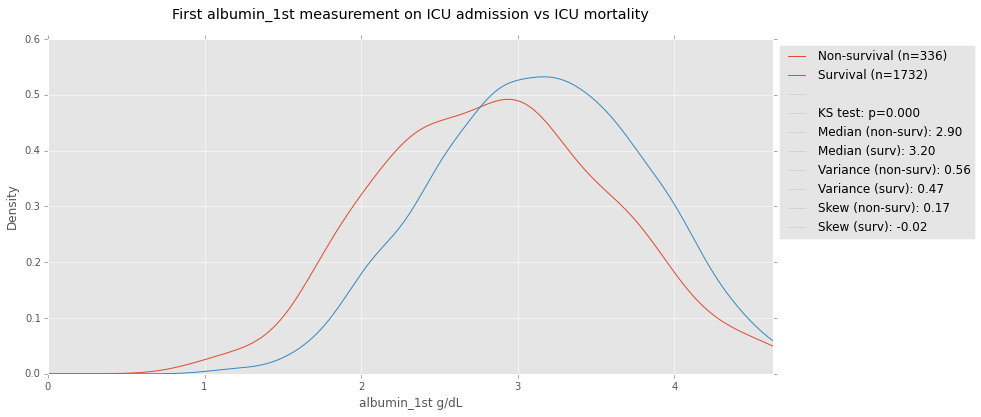

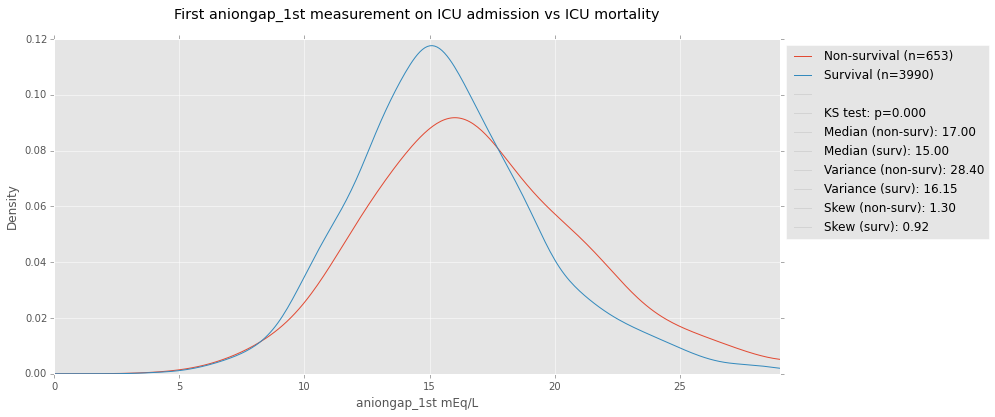

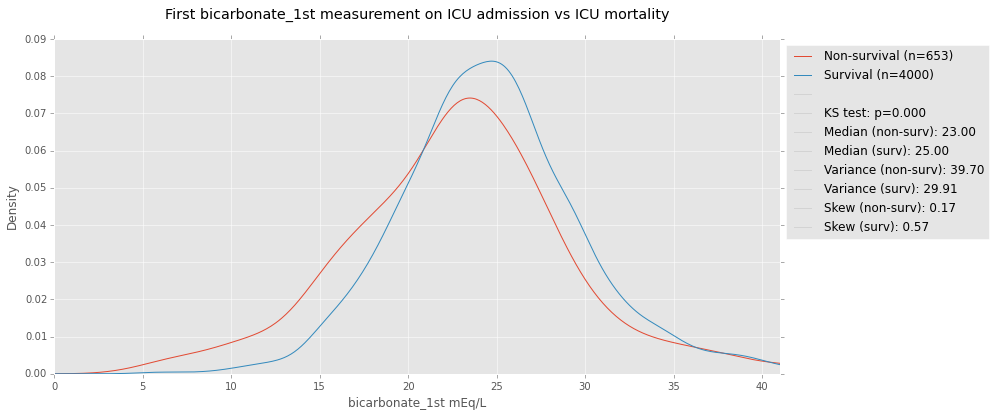

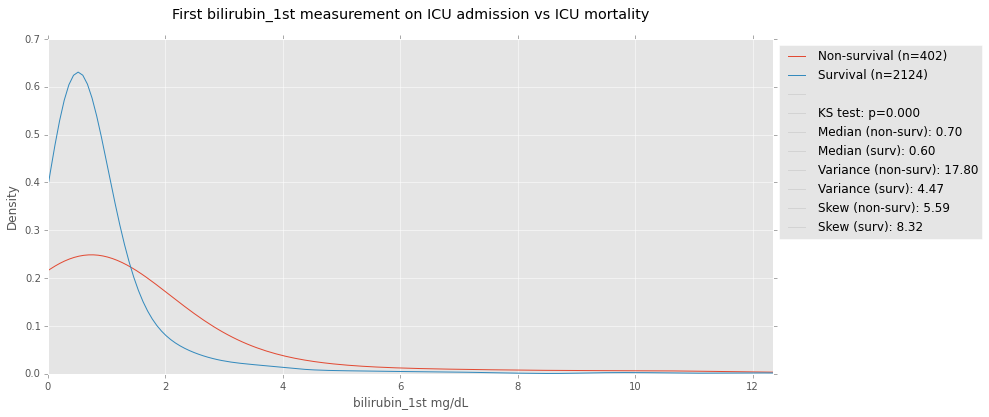

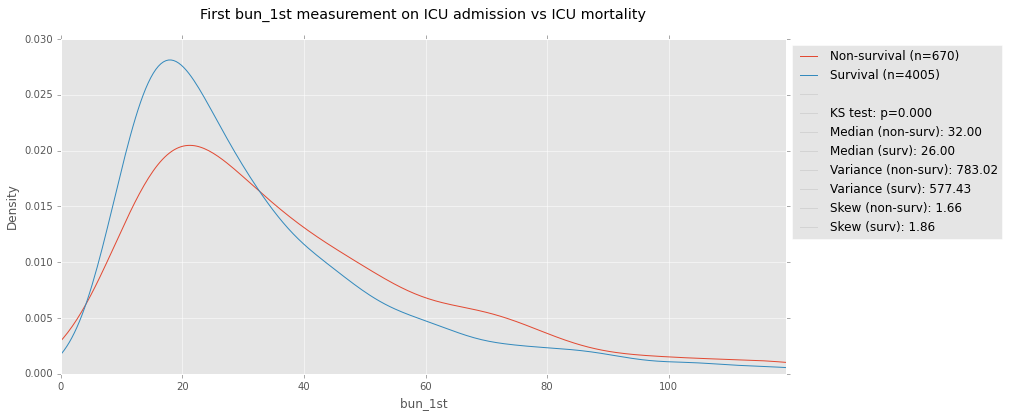

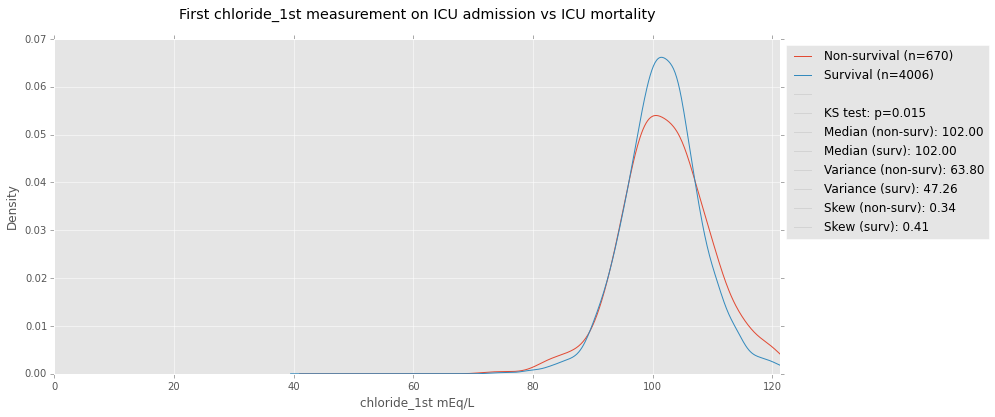

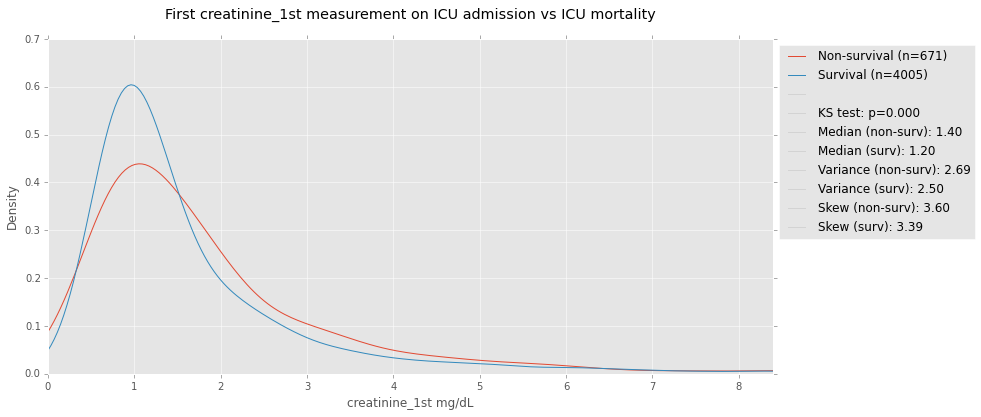

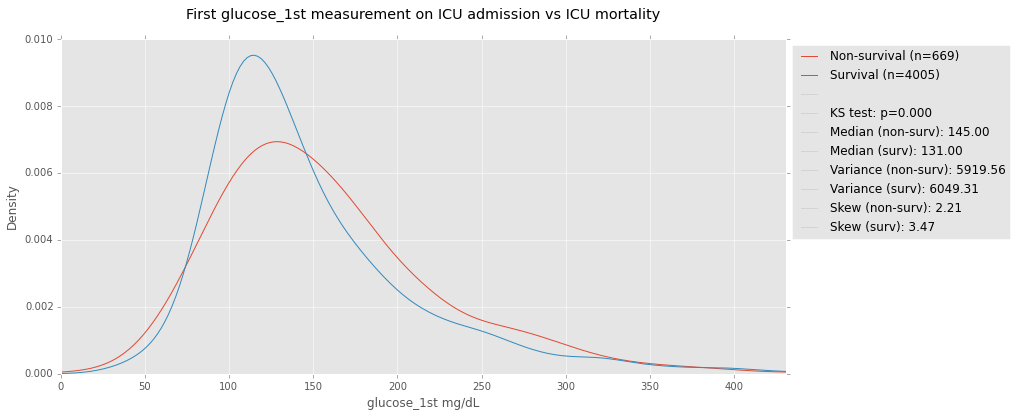

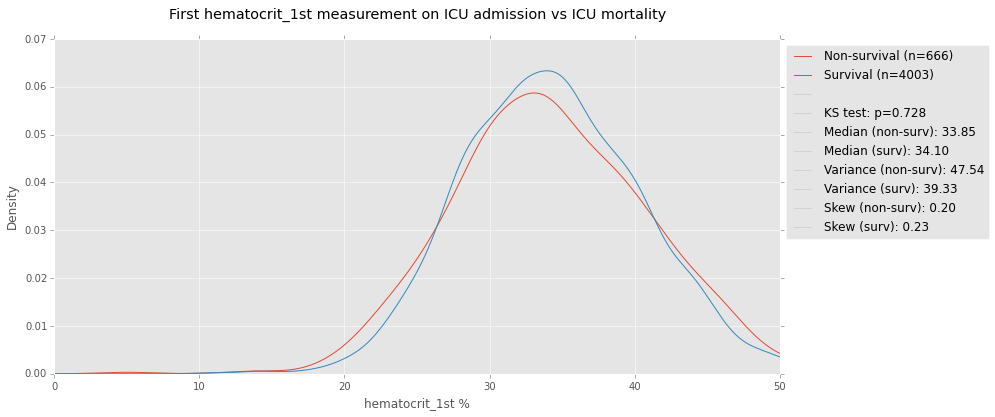

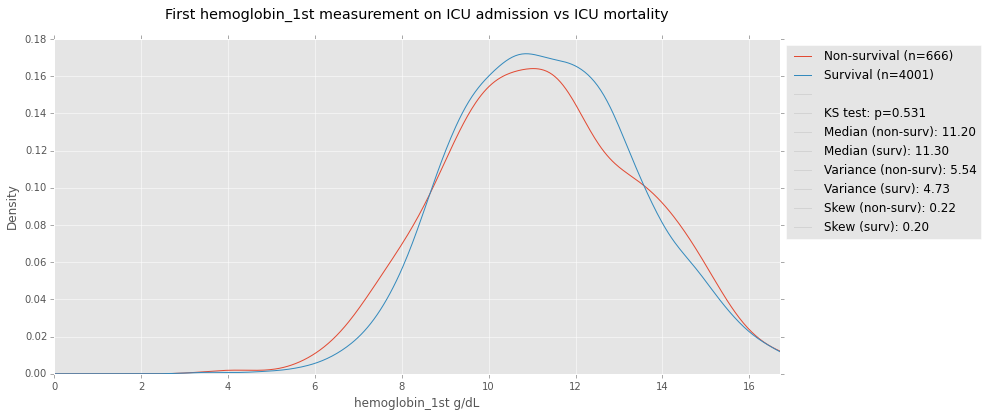

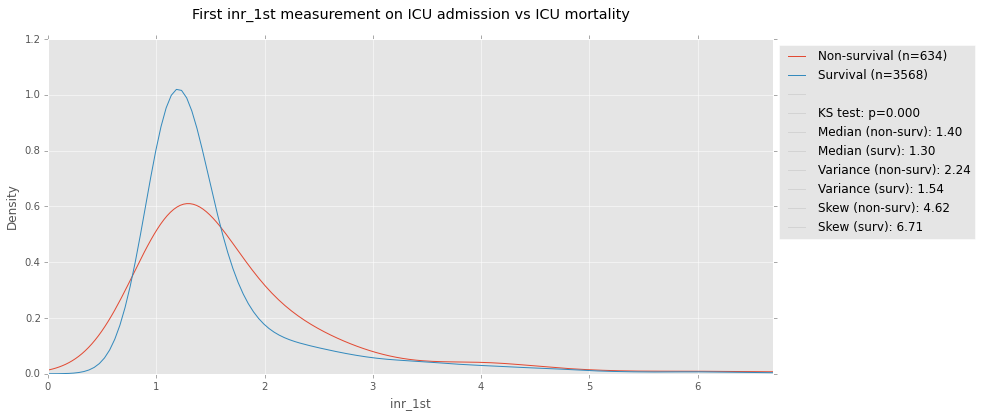

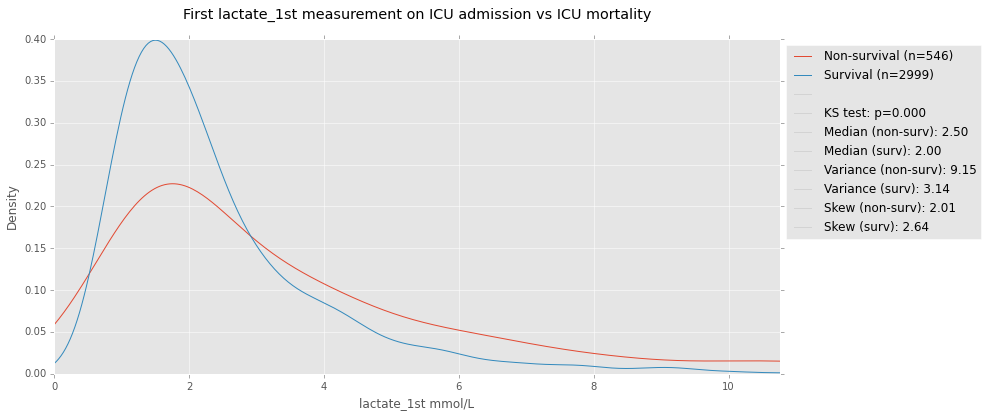

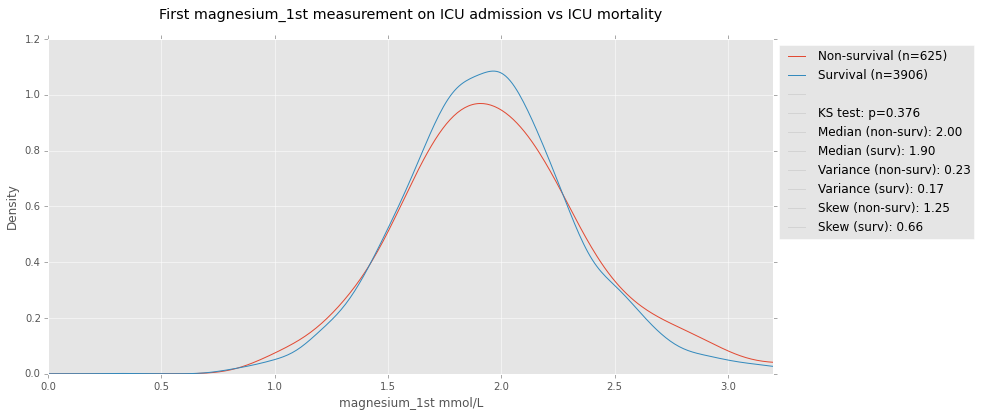

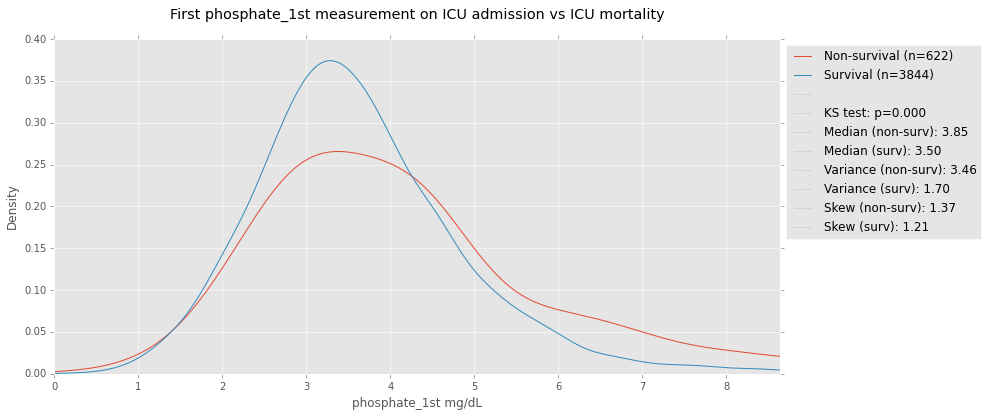

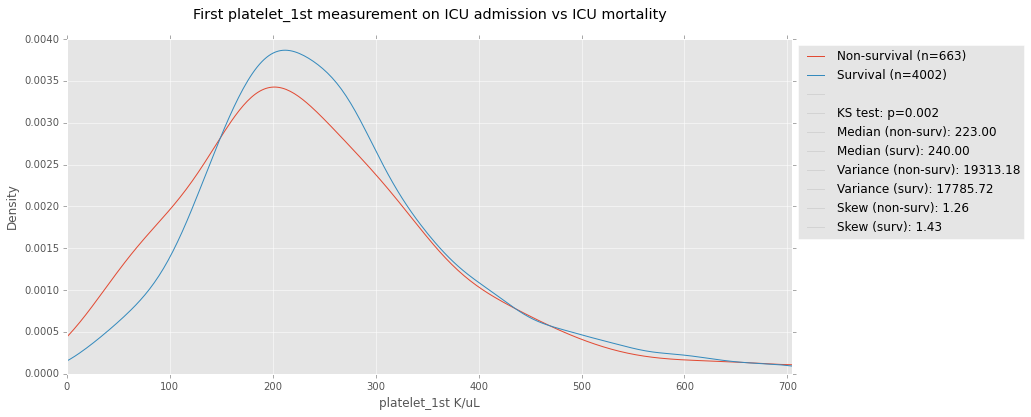

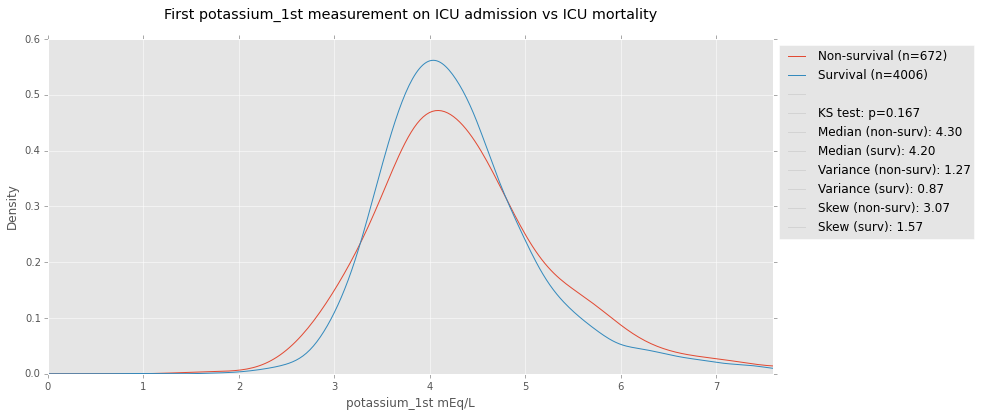

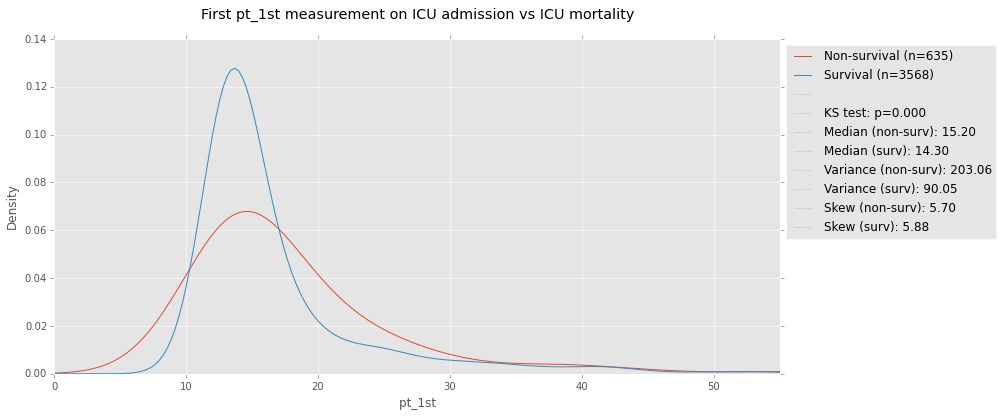

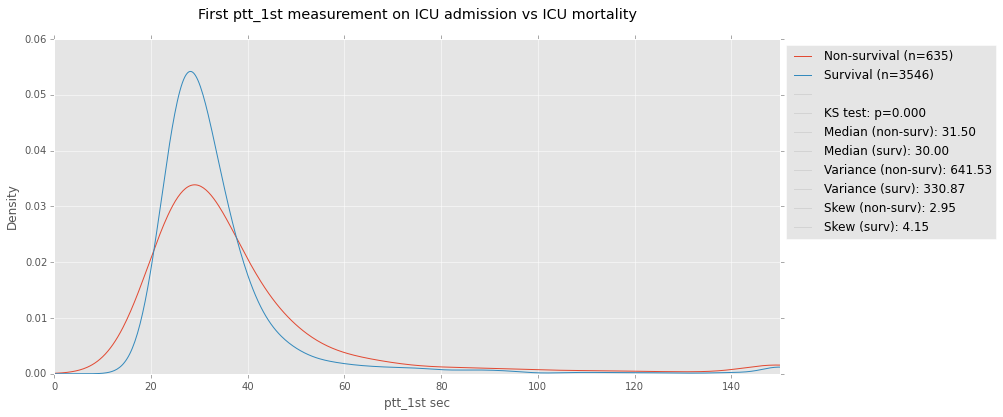

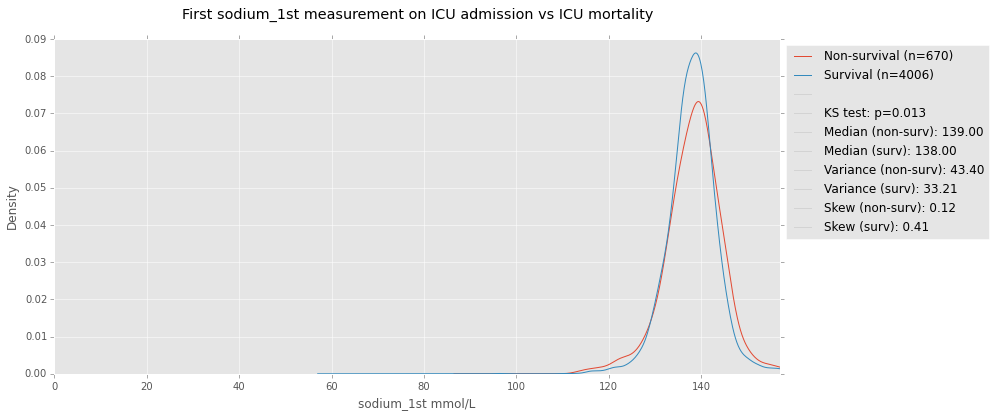

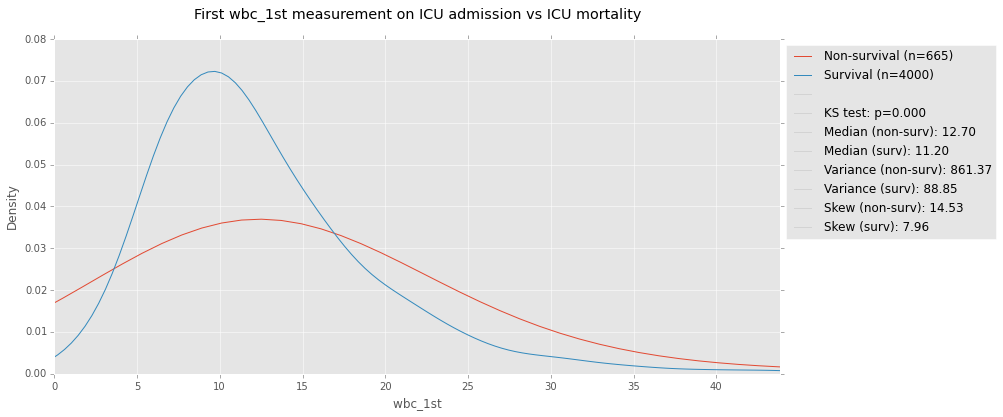

In [237]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

for l, u in iter(sorted(labs_dict.iteritems())):
    n_nonsurv = lab_results[l][lab_results.mort_icu==1].dropna().count()
    n_surv = lab_results[l][lab_results.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = lab_results[l][lab_results.mort_icu==1].dropna().median()
    med_surv = lab_results[l][lab_results.mort_icu==0].dropna().median()
    var_nonsurv = lab_results[l][lab_results.mort_icu==1].dropna().var()
    var_surv = lab_results[l][lab_results.mort_icu==0].dropna().var()
    skew_nonsurv = lab_results[l][lab_results.mort_icu==1].dropna().skew()
    skew_surv = lab_results[l][lab_results.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(lab_results[l][lab_results.mort_icu==1].dropna(),
                              lab_results[l][lab_results.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    lab_results[l][lab_results.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    lab_results[l][lab_results.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, lab_results[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')